In [89]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

# Import data, set target
df = pd.read_csv("winequalityN.csv")
target = 'quality'
df[target] = (df[target]>=7)*1

# Train-Test split
X = df.drop(columns=target)
y = df[[target]]
stratify = y # Make sure our split keep same distribution for our target in both train and test
test_size = 0.2 # each split will leave the test with 20% of the current data - it's is a common split ratio
shuffle = True # take random indexes of rows for each split, in case the data is not randomly sampled
random_state = 42 # use this specific random state - so we can reproduce our results if needed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=stratify, shuffle=shuffle, random_state=random_state)
stratify = y_train # The stratify split should change to the current target used
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=test_size, stratify=stratify, shuffle=shuffle, random_state=random_state)
# Validate outliers detection: Test if train outlier statistics are different than val outlier statistics
from scipy import stats
# Import the warnings module
import warnings

# Ignore the UserWarning from scipy.stats
# the warnings are saying we have less the 5000 samples so the noramlity test isn't accurate
warnings.filterwarnings("ignore", category=UserWarning, module="scipy.stats")

def test_if_significant(p_value, alpha=0.05, print_text=False):
    if p_value < alpha:
        if print_text:
            print(f"The means of the two populations are significantly different (alpha={alpha}).")
        return True
    else:
        if print_text:
            print("The means of the two populations are NOT significantly different (alpha={alpha}).")
        return False

def test_if_features_statistically_different(the_X_train, dfs_dict, alpha=0.05):
    '''Check if mean of numerical features in X_train and dfs_dict are statistically the same, for specified significance level
       return a df means, their difference and an answer the the question:
       Are the means statistically not different?'''
    # get train numeric features means
    train_val_outlier_means = the_X_train.describe().T.add_suffix('_train')['mean_train']
    for the_df_name, the_df in dfs_dict.items():
        # get other df numeric features means
        the_df_name = the_df_name.split("X_")[1]
        X_df_outlier_means = the_df.describe().T.add_suffix(f'_{the_df_name}')[f'mean_{the_df_name}']
        # concat the other df means to the same dataframe
        train_val_outlier_means = pd.concat([train_val_outlier_means, X_df_outlier_means], axis=1)
        # calc the mean for both, just to get a sense of the size of difference
        train_val_outlier_means['difference'] = (train_val_outlier_means['mean_train'] - train_val_outlier_means[f'mean_{the_df_name}']).round(3)
        for feature in train_val_outlier_means.index:
            # test the normality of the difference
            statatistic, p_value = stats.shapiro(the_X_train[feature] - the_df[feature])
            train_val_outlier_means.loc[feature, f'{the_df_name} difference is normal with {int((1-alpha)*100)}% significance'] = not test_if_significant(p_value, alpha=alpha)
            # perform the two-sample t-test for difference in means,
            t_statistic, p_value = stats.ttest_ind(the_X_train[feature], the_df[feature])
            train_val_outlier_means.loc[feature, f'{the_df_name} mean is the same with {int((1-alpha)*100)}% significance'] = not test_if_significant(p_value, alpha=alpha)
    return train_val_outlier_means

# Show all columns (don't replace some with "...")
pd.set_option('display.max_columns', None)
alpha = 0.01 # significance level
dfs_dict_to_test = {'X_val': X_val, 'X_test': X_test}
train_val_outlier_means_test = test_if_features_statistically_different(X_train, dfs_dict_to_test, alpha=alpha)
#print('\n# Test if train, validation and test sets means are statisically not different:\n', train_val_outlier_means_test)

# Missing Values imputation
# Create a variable to hold all train statistics,
# and insert the features with missing data, and transpose the matrix
train_statistics = X_train.describe(include='all').T
# Add a column to flag features with missing values
len_X_train = len(X_train)
train_statistics['has_na'] = (train_statistics['count'] < len_X_train)*1
statisticis_to_show = train_statistics.loc[train_statistics['has_na']==True, ['mean','has_na']]

# Create a function for missing values imputation, as we will imputate 3 times:
# for train, for valiation and for test
def imputate_missing_values(dataset_name, dataset, the_train_statistics, n_rows_to_show=5, add_print=True):
    # get a dict of missing values per each feature
    mean_values = the_train_statistics["mean"].to_dict()
    # impute missing values, and save those indexes
    missing_indexes = dataset[dataset.isna().any(axis=1)].index
    if add_print:
        to_show = dataset.loc[missing_indexes][:n_rows_to_show]
        print(f"# First {n_rows_to_show} original {dataset_name} missing values:\n{to_show}\n")
    # fill the missing values in X_train with the mean values
    dataset = dataset.fillna(value=mean_values)
    if add_print:
        to_show = dataset.loc[missing_indexes][:n_rows_to_show]
        print(f"# First {n_rows_to_show} imputed {dataset_name} missing values:\n{to_show}\n")
        missing_values = dataset.isna().sum()
        print(f"# The number of missing values in columns in {dataset_name}:\n{missing_values}\n")
    return dataset

# Impute missing values
X_train = imputate_missing_values('X_train', X_train, train_statistics, add_print=False)
X_val = imputate_missing_values('X_val', X_val, train_statistics, add_print=False)
X_test = imputate_missing_values('X_test', X_test, train_statistics, add_print=False)

def one_hot_encode_categoricals(the_df, categorical_features=['type'], drop_one=True, categories_to_use_from_train=None):
    # Create the numerical encodings
    one_hot_encodings = pd.get_dummies(the_df[categorical_features], drop_first=drop_one)
    # if val or test, filter categories to the ones that were used in train
    if categories_to_use_from_train:
        one_hot_encodings = one_hot_encodings[categories_to_use_from_train]
    one_hot_encodings_categories = one_hot_encodings.columns
    # Add the encodings to the dataset
    the_df = pd.concat([the_df, one_hot_encodings], axis=1)
    # Drop the original categorical_features
    the_df = the_df.drop(columns=categorical_features)
    return the_df, one_hot_encodings_categories

# Define parameters for the functions: cateorical features names, and if should one categoy be dropped for every feature
categorical_features=['type']
drop_one = True
# Encode categoricals for train, get back the train categories
X_train, train_categories = one_hot_encode_categoricals(X_train, categorical_features=categorical_features, drop_one=drop_one)

# Add new train cateogories statistics to train_statistics
def add_new_features_statistics_to_train_statistics(the_train, the_train_statistics, new_features):
    'Add new features statistics to train_statistics'
    train_new_features_statistics = the_train[new_features].describe(include='all').T
    the_train_statistics = pd.concat([the_train_statistics, train_new_features_statistics], axis=0)
    return the_train_statistics
train_statistics = add_new_features_statistics_to_train_statistics(X_train, train_statistics, train_categories)

def add_binary_property_to_train_statistics(the_train_statistics, the_property, features_list_with_property):
    "Add a binary property column (starting with 'is_') to group of features"
    if not the_property in train_statistics:
        the_train_statistics[the_property] = 0
    the_train_statistics.loc[features_list_with_property, the_property] = 1
    return the_train_statistics


# Add proprty 'is_categorical_to_drop' to original cateogorical features
train_statistics = add_binary_property_to_train_statistics(train_statistics, 'is_categorical_to_drop', categorical_features)
# Add proprty 'is_category' to newly created categories one-hot-encoding features
train_statistics = add_binary_property_to_train_statistics(train_statistics, 'is_category', train_categories)

def get_train_feautres_with_property(the_train_statistics, the_property):
    "Extract list of features with property from train_statistics"
    the_features = train_statistics[train_statistics[the_property]==1].index.tolist()
    return the_features


# Get category features and categories of train, from train_statistics
categorical_features = get_train_feautres_with_property(train_statistics, 'is_categorical_to_drop')
categories_to_use_from_train = get_train_feautres_with_property(train_statistics, 'is_category')
# Create a partial function, pre-set with these parameters, to be run on both X_val and X_test
from functools import partial
one_hot_encode_categoricals_fn = partial(one_hot_encode_categoricals, categorical_features=categorical_features, categories_to_use_from_train=categories_to_use_from_train)
X_val, _ = one_hot_encode_categoricals_fn(X_val)
X_test, _ = one_hot_encode_categoricals_fn(X_test)

# add kurtosis and skew statistics

from scipy.stats import kurtosis, skew

def add_kurtosis_skew_statistics(the_df, the_train_statistics):
    the_train_statistics['kurtosis'] = the_df.apply(kurtosis)
    the_train_statistics['skew'] = the_df.apply(skew)
    the_train_statistics['is_many_outliers'] = (the_train_statistics['kurtosis']>=3)*1
    the_train_statistics['is_right_skew'] = (the_train_statistics['skew']>0)*1
    return the_train_statistics

train_statistics = add_kurtosis_skew_statistics(X_train, train_statistics)

# Detect Outliers
def add_outlier_indicator(the_df: pd.DataFrame, the_feature: pd.Series, the_train_statistics: pd.DataFrame, outlier_col_suffix='is_outlier', is_train=False) -> pd.DataFrame:
    ''' Find outliers for given feature in df, mark outlier cells with 1, return new outlier columns'''
    outlier_col = the_feature + "_" + outlier_col_suffix
    # Create is_outlier col if it doesn't exist, and fill with 0 (i.e. no outliers)
    if not outlier_col in the_df:
        the_df[outlier_col] = 0
    # The formula for calculating a z-score is: Z = (X - μ) / σ
    X = the_df[the_feature]
    μ = the_train_statistics.loc[the_feature, 'mean']
    σ = the_train_statistics.loc[the_feature, 'std']
    obs_z_scores = (X - μ)/σ
    # Get all rows with outliers
    outliers = obs_z_scores.abs() > 3
    # Mark outliers
    if sum(outliers) > 0:
        the_df.loc[outliers, outlier_col] = 1
    else:
        if is_train: # if train and no outliers, drop column. if val or test, keep zeros.
            the_df = the_df.drop(columns=outlier_col)

    return the_df, outlier_col

from typing import List

def add_outlier_indicators_on_features(the_df: pd.DataFrame, the_train_statistics: pd.DataFrame, X_train_numeric_features: List = None, outlier_col_suffix='is_outlier') -> pd.DataFrame:
    ''' If the_features=None, assume train and find outliers for all numeric features
        If the_features=[given list], assume val or test and find outliers on specific columns
        return dataset with new outlier columns and 0/1 indicators for outlier cells
    '''
    # If the_features not defined (first run on train), filter out non-numeric features and run on all
    if not X_train_numeric_features:
        is_train = True
        categories = get_train_feautres_with_property(train_statistics, 'is_category')
        X_train_numeric_features = [col for col in X_train.columns if not col in categories]
    else:
        is_train = False # either validation or test
    new_outlier_cols = []
    for feature in X_train_numeric_features:
        the_df, new_outlier_col = add_outlier_indicator(the_df, feature, the_train_statistics, outlier_col_suffix=outlier_col_suffix, is_train=is_train)
        new_outlier_cols = new_outlier_cols + [new_outlier_col]
    return the_df, new_outlier_cols


# Add outlier column indicator, having 1 for outlier rows
X_train_numeric_features = None # When none, assume train dataset and find all relevent columns
outlier_col_suffix = 'is_outlier'
X_train, train_outiler_cols = add_outlier_indicators_on_features(X_train, train_statistics, X_train_numeric_features=X_train_numeric_features, outlier_col_suffix=outlier_col_suffix)

# Update outlier statistics to train_statistics
train_statistics = add_new_features_statistics_to_train_statistics(X_train, train_statistics, train_outiler_cols)
#print("# Updated train_statistics: \n", train_statistics)

## Apply outlier indicators on validation and test
def get_train_features_with_suffix(the_train_statistics, remove_suffix=True, the_suffix='is_outlier'):
    the_train_statistics_features = the_train_statistics.index.to_list()
    feautres_with_suffix = [feature for feature in the_train_statistics_features if feature.endswith(the_suffix)]
    if remove_suffix:
        feautres_with_suffix = [feature.split("_"+the_suffix)[0] for feature in feautres_with_suffix]
    return feautres_with_suffix
# get train outlier columns
train_outiler_cols = get_train_features_with_suffix(train_statistics, the_suffix=outlier_col_suffix)
# Add outlier indicators to val and test in those specific features
add_outlier_indicators_on_features_fn = partial(add_outlier_indicators_on_features, the_train_statistics=train_statistics, X_train_numeric_features=train_outiler_cols, outlier_col_suffix=outlier_col_suffix)
X_val, _ = add_outlier_indicators_on_features_fn(X_val)
X_test, _ = add_outlier_indicators_on_features_fn(X_test)

# Validate outliers detection: Test if train outlier statistics are different than val outlier statistics
remove_suffix=False
train_outlier_cols = get_train_features_with_suffix(train_statistics, the_suffix=outlier_col_suffix, remove_suffix=remove_suffix)
remove_suffix=True
train_orig_outlier_cols = get_train_features_with_suffix(train_statistics, the_suffix=outlier_col_suffix, remove_suffix=remove_suffix)
#X_train_outliers = X_train.loc[(X_train[train_outlier_cols]==1).any(axis=1), train_orig_outlier_cols]
#X_val_outliers = X_val.loc[(X_val[train_outlier_cols]==1).any(axis=1), train_orig_outlier_cols]
#print(f"\n# The train outliers:\n {X_train_outliers}")
#alpha = 0.01 # significance level
#dfs_dict_to_test = {'X_val_outliers': X_val_outliers}
#train_val_outlier_means_test = test_if_features_statistically_different(X_train_outliers, dfs_dict_to_test, alpha=alpha)
#print('\n# Test if train and validation outliers means are statisically not different:\n', train_val_outlier_means_test)

# Impute outliers features

def add_winsorization_values_to_train_statistics(the_X_train, the_train_statistics, percentiles=[.05,.95]):
    '''Add percentile data to train_statistics, to later be used for winsorization'''
    winsorization_values = the_X_train.describe(include='all', percentiles=[.05,.95]).T
    percentile_col_names = [str(col).split(".")[1].replace("0","")+"%" for col in percentiles]
    the_train_statistics = pd.concat([the_train_statistics, winsorization_values[percentile_col_names]],axis=1)
    return the_train_statistics

def winsorize_outliers(the_df, the_train_statistics, percentiles=[.05,.95]):
    # extract original outlier call and is_outliers cols
    remove_suffix=False
    train_outlier_cols = get_train_features_with_suffix(train_statistics, the_suffix=outlier_col_suffix, remove_suffix=remove_suffix)
    remove_suffix=True
    train_orig_outlier_cols = get_train_features_with_suffix(train_statistics, the_suffix=outlier_col_suffix, remove_suffix=remove_suffix)
    outlier_cols_mapper = dict(zip(train_orig_outlier_cols, train_outlier_cols))
    # extract winsorization values
    percentile_col_names = [str(col).split(".")[1].replace("0","")+"%" for col in percentiles]
    winsorization_values = the_train_statistics.loc[train_orig_outlier_cols, percentile_col_names].T
    # replace min/max outliers with min_winzor/max_winzor
    for orig_col, is_outlier_col in outlier_cols_mapper.items():
        min_winzor = winsorization_values[orig_col].min()
        max_winzor = winsorization_values[orig_col].max()
        outlier_rows = the_df[is_outlier_col]==1
        min_outliers = the_df[orig_col]<=min_winzor
        max_outliers = the_df[orig_col]>=max_winzor
        the_df.loc[(outlier_rows)&(min_outliers),orig_col] = min_winzor
        the_df.loc[(outlier_rows)&(max_outliers),orig_col] = max_winzor

    return the_df

train_statistics = add_winsorization_values_to_train_statistics(X_train, train_statistics)
#print("# Updated train_statistics: \n", train_statistics)

X_train = winsorize_outliers(X_train, train_statistics)
X_val = winsorize_outliers(X_val, train_statistics)
X_test = winsorize_outliers(X_test, train_statistics)

#X_train_outliers_mean = X_train.loc[(X_train[train_outlier_cols]==1).any(axis=1), train_orig_outlier_cols].mean().rename("Outlier rows means")
#X_train_imputed_outliers_mean = X_train.loc[(X_train[train_outlier_cols]==1).any(axis=1), train_orig_outlier_cols].mean().rename("Imputed outlier rows means")
#X_train_imputed_outliers_mean = pd.concat([X_train_outliers_mean, X_train_imputed_outliers_mean], axis=1)
#print(f"\n# See how the means of the outliers rows changed after the imputations:\n {X_train_imputed_outliers_mean}")
#print(train[X_train[train_outlier_cols]==1])
#print(X_train)

# Engineer new features

def add_polynomial_features(the_df, features_to_add=None, suffix='_squared'):
    'For each feature in features_to_quare, add the_df the power of 2 of that feature'
    if features_to_add is None:
        features_to_add = ['alcohol','density']
    new_features_list = []
    for feature in features_to_add:
        new_feature = feature + suffix
        the_df[new_feature] = the_df[feature] ** 2
        new_features_list = new_features_list + [new_feature]
    return the_df, new_features_list

def add_combination_features(the_df, features_to_add=None):
    'For each feature in features_to_add, add the_df the result of the formula of that feature'
    if features_to_add is None:
        features_to_add = ['total acidity', 'combined sulfur dioxide', 'mso2']
    new_features_list = features_to_add
    for feature in features_to_add:
        if feature == 'total acidity':
            the_df[feature] = the_df['fixed acidity'] + the_df['volatile acidity']
        if feature == 'combined sulfur dioxide':
            the_df[feature] = the_df['total sulfur dioxide'] - the_df['free sulfur dioxide']
        if feature == 'mso2':
            the_df[feature] = (1+10**(the_df['pH']-1.81))
    return the_df, new_features_list

def add_interaction_features(the_df, features_tuples_list_to_add=None):
    'For each pair of features in features_tuples_list_to_add, add the_df the multiplication of the features'
    if features_tuples_list_to_add is None:
        features_tuples_list_to_add = [ ('total sulfur dioxide', 'alcohol'),
                                        ('chlorides','volatile acidity'),
                                        ('density','citric acid')
                                        ]
    new_features_list = []
    for feature1, feature2  in features_tuples_list_to_add:
        new_feature = feature1 + "_X_" + feature2
        the_df[new_feature] = the_df[feature1] * the_df[feature2]
        new_features_list = new_features_list + [new_feature]
    return the_df, new_features_list

def add_ratio_features(the_df, features_tuples_list_to_add=None):
    'For each pair of features in features_tuples_list_to_add, add the_df the ration of the features'
    if features_tuples_list_to_add is None:
        features_tuples_list_to_add = [ ('total acidity', 'free sulfur dioxide'),
                                        ('free sulfur dioxide','total sulfur dioxide'),
                                        ('total acidity','pH'),
                                        ('citric acid','fixed acidity'),
                                        ('alcohol','density'),
                                        ('residual sugar','chlorides'),
                                        ]
    new_features_list = []
    for feature1, feature2  in features_tuples_list_to_add:
        new_feature = feature1 + "_/_" + feature2
        the_df[new_feature] = the_df[feature1] / the_df[feature2]
        new_features_list = new_features_list + [new_feature]
    return the_df, new_features_list


def engineer_new_features(the_df, add_functions_list=None, features_to_add_list=None):
    'For each adding function and features to add, apply the function on the_df'
    if add_functions_list is None:
        add_functions_list = [add_polynomial_features,
                              add_combination_features,
                              add_interaction_features,
                              add_ratio_features]
    if features_to_add_list is None:
        features_to_add_list = [None,
                                None,
                                None,
                                None]
    new_features_list = []
    for a_func, features_to_add in zip(add_functions_list, features_to_add_list):
        the_df, func_new_features_list = a_func(the_df, features_to_add)
        new_features_list = new_features_list + func_new_features_list
    return the_df, new_features_list


X_train, new_features_list = engineer_new_features(X_train)
X_val, _ = engineer_new_features(X_val)
X_test, _ = engineer_new_features(X_test)
#print('# X_train new engineered features:\n', X_train[new_features_list])
train_statistics = add_new_features_statistics_to_train_statistics(X_train, train_statistics, new_features_list)
train_statistics = add_binary_property_to_train_statistics(train_statistics, 'is_engineered', new_features_list)
train_statistics = add_binary_property_to_train_statistics(train_statistics, 'is_engineered', [feature+"_is_outlier" for feature in train_outiler_cols]) # outlier features are also engineered
#print("\n# Updated train_statistics: \n", train_statistics)
n_new_features = train_statistics['is_engineered'].sum()
#print(f"\n# Including outliers, we have succuesfully created {n_new_features} new engineered features!")


# Drop highly correlated features

def get_multicollinear_features(features_list, df_multicollinear_corr, add_print=False):
    """using a correlatin matrix df_multicollinear_corr and a list of features to test,
    return a list of highly correlated features (compared to the list of features to test)"""
    multicollinear_feautres = {}
    for feature in features_list:
        feature_val_counts = df_multicollinear_corr[feature].value_counts()
        if len(feature_val_counts)>0:
            features_high_corr = df_multicollinear_corr[feature].dropna()
            if add_print:
                print(f"\n{features_high_corr}")
            multicollinear_feautres[feature] = features_high_corr.index.tolist()
    engineered_correlated_feautures = pd.DataFrame.from_dict(multicollinear_feautres, orient='index').reset_index().drop(columns='index').stack().drop_duplicates().values
    return engineered_correlated_feautures


def drop_high_correlation_features(the_df, the_train_statistics, method='pearson', high_corrleation_threshold=0.9, add_print=False):
    if add_print:
        print(f"\n# Each feature's high pearson correlations (at least {high_corrleation_threshold}):")
    df_corr = the_df.corr(method='pearson')
    # Get all high correlations features' sets
    df_corr = df_corr[(df_corr.abs()>=high_corrleation_threshold)&(df_corr.abs()!=1)].dropna(how='all')
    # get engineered highly correlated features
    orig_features = the_train_statistics[the_train_statistics['is_engineered'] == 0].index
    orig_features = [col for col in orig_features if col in df_corr]
    engineered_correlated_feautures = get_multicollinear_features(orig_features, df_corr, add_print=add_print)
    if add_print:
        print(f"\nThere are {len(engineered_correlated_feautures)} high correlated engineered feautres (>={high_corrleation_threshold}):\n{engineered_correlated_feautures}")
    # drop engineered highly correlated features
    the_df = the_df.drop(columns=engineered_correlated_feautures)
    if add_print:
        print(f"After dropping highly correlated engineered features (>={high_corrleation_threshold}, there are {len(the_df.columns)} features in dataset")
    all_correlated_dropped_features = engineered_correlated_feautures
    # get remaining highly correlated features
    remaining_features = the_train_statistics[the_train_statistics['is_engineered'] == 1].index
    remaining_features = [col for col in remaining_features if col in df_corr if col in the_df]
    remaining_correlated_feautures = get_multicollinear_features(remaining_features, df_corr, add_print=add_print)
    if add_print:
        print(f"There are {len(remaining_correlated_feautures)} high correlated remaining feautres (>={high_corrleation_threshold}):\n{remaining_correlated_feautures}")
    if len(remaining_correlated_feautures)>0:
        # drop remaining highly correlated features
        the_df = the_df.drop(columns=remaining_correlated_feautures)
        if add_print:
            print(f"After dropping highly correlated remaining features (>={high_corrleation_threshold}, there are {len(the_df.columns)} features in dataset")
        all_correlated_dropped_features = all_correlated_dropped_features + remaining_correlated_feautures
    return the_df, all_correlated_dropped_features

add_print=False
X_train, correlated_dropped_features = drop_high_correlation_features(X_train, train_statistics, method='pearson', high_corrleation_threshold=0.9, add_print=add_print)
train_statistics = add_binary_property_to_train_statistics(train_statistics, 'is_correlated_to_drop', correlated_dropped_features)
correlated_dropped_features = get_train_feautres_with_property(train_statistics, 'is_correlated_to_drop')
X_val = X_val.drop(columns=correlated_dropped_features)
X_test = X_test.drop(columns=correlated_dropped_features)

#print(f"\n# Updated X_train after highly correalted features dropped:\n{X_train}")

#print(f"\n# Current correlations in X_train:\n{X_train.corr()}")

# Normalize dataset

def standardize_df_using_train_statistics(the_df, the_train_statistics, add_print=False):
    for feature in the_df:
        μ = the_train_statistics.loc[the_train_statistics.index==feature, 'mean'].values
        σ = the_train_statistics.loc[the_train_statistics.index==feature, 'std'].values
        the_df[feature] = (the_df[feature] - μ) / σ
    if add_print:
        print("\n # The standardized features means and standard deviations:\n")
        print(the_df.agg(['mean','std']).round(3))
    return the_df

# Update train_statistics with current X_train mean and std
train_statistics['mean'] = X_train.mean().T
train_statistics['std'] = X_train.std().T
# standardize train, validation and test
add_print=False
X_train = standardize_df_using_train_statistics(X_train, train_statistics, add_print=add_print)
add_print=False
X_val = standardize_df_using_train_statistics(X_val, train_statistics, add_print=add_print)
X_test = standardize_df_using_train_statistics(X_test, train_statistics, add_print=add_print)

#print("\n # The new standardized train set:\n")
#print(X_train)

# Balance Target

def upsample_target_minority(the_df, the_train_statistics, random_state=42):
    """Upsample target minority so that the target classes will be balacned, return feature and target seperately"""
    # Extract target name from train_statistics
    target = the_train_statistics[the_train_statistics['is_target']==1].index[0]
    # get the number of rows of majority class and the classes values
    target_mean = the_train_statistics.loc[the_train_statistics.index==target, 'mean'][0]
    if target_mean>=0.5:
        majority_pct = target_mean
        minority_class = 0
        majority_class = 1
    else:
        majority_pct =  1 - target_mean
        minority_class = 1
        majority_class = 0

    df_size = len(the_df)
    majority_N_rows = int(np.floor(majority_pct*df_size))
    # Resample the minorty class (with replacemnt) to the number of rows in majority class
    the_df_minorty = the_df[the_df[target]==minority_class]
    the_df_majority = the_df[the_df[target]==majority_class]
    the_df_minorty = the_df_minorty.sample(majority_N_rows, random_state=random_state, replace=True)
    # Concat the rows back together, and shuffle the df
    the_df = pd.concat([the_df_minorty, the_df_majority], axis=0)
    the_df = the_df.sample(frac=1)
    # split the features and the target to two dfs
    the_target_df = the_df[target]
    the_target_features = the_df.drop(columns=target)
    return the_target_features, the_target_df

def add_target_to_train_statistics(the_train_target, the_train_statistics, target='quality'):
    # get target statistics
    target_statistics = the_train_target.describe(include='all').T
    # add target statistics to train statistics
    the_train_statistics = pd.concat([target_statistics, the_train_statistics], axis=0)
    # add is_target property
    the_train_statistics = add_binary_property_to_train_statistics(the_train_statistics, 'is_target', target)
    # move is_target property to first column
    the_train_statistics = pd.concat([the_train_statistics['is_target'], the_train_statistics.drop(columns=['is_target'])], axis=1)
    return the_train_statistics

# Update train statistics with the target distribution and mark
train_statistics = add_target_to_train_statistics(y_train, train_statistics, target)

# Concatenate the feature with the target before upsampling
train = pd.concat([X_train, y_train], axis=1)
val = pd.concat([X_val, y_val], axis=1)

upsample_target_minority_fn = partial(upsample_target_minority, the_train_statistics=train_statistics, random_state=42)
X_train, y_train = upsample_target_minority_fn(train)
#print(f"\n# After upsampling, the current train target distribution is:\n{y_train.value_counts(normalize=False, dropna=False)}")


The most basic model, without engineered features: 
The number of features in X_train_orig is 12
The number of features in X_val_orig is 12
confusion matrix:
      0    1
0  524  312
1   47  157
The Model's Metrics:
               precision    recall  f1-score   support

           0       0.92      0.63      0.74       836
           1       0.33      0.77      0.47       204

    accuracy                           0.65      1040
   macro avg       0.63      0.70      0.61      1040
weighted avg       0.80      0.65      0.69      1040



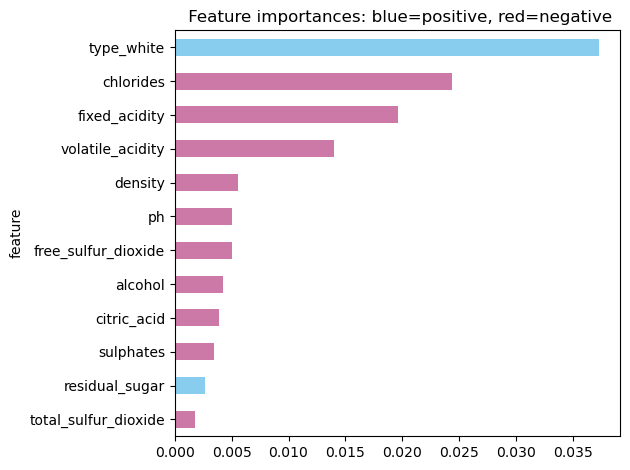

In [12]:
# final preprocessing
def replace_columns_spaces_with_underscores(the_df):
    the_df.columns = the_df.columns.str.replace("_/_","/")
    the_df.columns = the_df.columns.str.replace(" ","_")
    return the_df

def drop_features(the_df, features_to_drop, errors='ignore'):
    the_df = the_df.drop(columns=features_to_drop, errors=errors)
    return the_df

def drop_features_with_train_statistics_property(the_df, the_train_statistics, property_list, errors='ignore'):
    ## drop categorical already-encoded features, and highly correlated features:
    for type_of_features_to_drop in property_list:
        features_to_drop = get_train_feautres_with_property(train_statistics, type_of_features_to_drop)
        the_df = drop_features(the_df, features_to_drop=features_to_drop, errors=errors)
    return the_df

types_of_features_to_drop = ['is_categorical_to_drop', 'is_correlated_to_drop']
dropping_errors = 'ignore' # don't report if feature is missing
## drop highly correlated features:
drop_features_with_train_statistics_property_fn = partial(
    drop_features_with_train_statistics_property, the_train_statistics=train_statistics,
    property_list=types_of_features_to_drop, errors=dropping_errors)

# fix columns names
X_train = replace_columns_spaces_with_underscores(X_train)
X_val = replace_columns_spaces_with_underscores(X_val)
X_test = replace_columns_spaces_with_underscores(X_test)
train_statistics = replace_columns_spaces_with_underscores(train_statistics.T).T

# Basline model
print("The most basic model, without engineered features: ")
types_of_features_to_drop = ['is_engineered']
## drop engineered features:
drop_features_with_train_statistics_property_fn = partial(
    drop_features_with_train_statistics_property, the_train_statistics=train_statistics,
    property_list=types_of_features_to_drop, errors=dropping_errors)

X_train_orig = drop_features_with_train_statistics_property_fn(X_train)
X_val_orig = drop_features_with_train_statistics_property_fn(X_val)

print(f"The number of features in X_train_orig is {len(X_train_orig.columns)}")
print(f"The number of features in X_val_orig is {len(X_val_orig.columns)}")
## Modeling using Gaussian Naive Bayes - https://scikit-learn.org/stable/modules/naive_bayes.html
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(X_train_orig, y_train).predict(X_val_orig)

## confusion matrix

from sklearn.metrics import confusion_matrix, classification_report

conf_matrix = pd.DataFrame(confusion_matrix(y_val, y_pred))

print('confusion matrix:\n', conf_matrix)
print("The Model's Metrics:\n", classification_report(y_val, y_pred))


def move_cols_to_first(the_df, cols):
    other_cols = the_df.columns[~the_df.columns.isin(cols)]
    the_df = pd.concat([the_df[cols],the_df[other_cols]],axis=1)
    return the_df


## Feature importance

from sklearn.inspection import permutation_importance
from sklearn.feature_extraction.text import CountVectorizer


def reorder_feature_importance_by_abs_values(the_feature_importance, importance_col='importance'):
    feature_importance_index = the_feature_importance.copy(deep=True).abs().sort_values(by=importance_col, ascending=False).index
    the_feature_importance = the_feature_importance.loc[feature_importance_index]
    return the_feature_importance

def get_permutation_importance(the_model, the_X_train_orig, the_X_val_orig, the_y_val, random_state=0):
    imps = permutation_importance(the_model, the_X_val_orig, the_y_val, random_state=random_state)
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(the_X_train_orig)
    feature_names = count_vect.get_feature_names_out()
    the_feature_importance = zip(feature_names, imps.importances_mean)
    the_feature_importance = sorted(the_feature_importance, key=lambda x: x[1], reverse=True)
    the_feature_importance = pd.DataFrame(the_feature_importance)
    the_feature_importance.columns = ['feature','importance']
    the_feature_importance = the_feature_importance.set_index('feature')
    the_feature_importance = reorder_feature_importance_by_abs_values(the_feature_importance, importance_col='importance')
    return the_feature_importance

def plot_feature_importance(the_feature_importance, show_sign_color=True, show_only_important=True, model_name=""):
    the_feature_importance = the_feature_importance.copy(deep=True)
    # Color-blind friendly colors - #88CCEE” (light blue), #CC79A7” (reddish purple)
    if show_sign_color:
        the_feature_importance['color'] = np.where(the_feature_importance['importance'] >= 0, '#88CCEE', '#CC79A7')
        the_feature_importance['importance'] = the_feature_importance['importance'].abs()
    the_feature_importance = the_feature_importance.sort_values(by='importance', ascending=True)
    if show_only_important:
        the_feature_importance = the_feature_importance[the_feature_importance['importance']>0]
    if show_sign_color:
        the_feature_importance['importance'].plot.barh(color=the_feature_importance['color'].values, title=f'{model_name} Feature importances: blue=positive, red=negative')
    else:
        the_feature_importance['importance'].plot.barh(title='Feature importances')
    plt.tight_layout()


feature_importance = get_permutation_importance(gnb, X_train_orig, X_val_orig, y_val)
plot_feature_importance(feature_importance, show_sign_color=True, show_only_important=True)

In [91]:
from datetime import datetime




In [92]:
import os
from datetime import datetime


def get_model_metrics(the_y_val, the_y_pred, the_feature_importance, model, model_params, model_name='baseline', existing_model_metrics=None, export_to_csv=False):
    # if not existing_model_metrics, import existing metrics from folder if it exists, else create a new dataframe.
    # if existing_model_metrics - use the existing model metrics, in the end we'll append current results to existing.
    if existing_model_metrics is None:
        if 'model_metrics.csv' in os.listdir():
            the_model_metrics = pd.read_csv('model_metrics.csv', index_col=0)
        else:
            the_model_metrics = pd.DataFrame()
    else:
        the_model_metrics = existing_model_metrics.copy(deep=True)
    # create confusion matrix
    conf_matrix = pd.DataFrame(confusion_matrix(the_y_val, the_y_pred))
    conf_matrix = conf_matrix.stack().to_frame().T
    conf_matrix.columns = ['TN','FP','FN','TP']
    # create classification report
    class_report = pd.DataFrame(classification_report(the_y_val, the_y_pred, output_dict=True)).drop(columns=['macro avg', 'weighted avg'])
    class_report = pd.concat([class_report[class_report.index=='support'], class_report[class_report.index!='support']], axis=0)
    class_report = class_report.stack().to_frame().T
    class_report = pd.concat([conf_matrix, class_report], axis=1)
    class_report[[('support', '1'), ('support', '0')]] = class_report[[('support', '1'), ('support', '0')]].astype(int)
    ## create distribution 1, lift 1, lift 0
    class_report[('distribution', '1')] = class_report[('support', '1')] / (class_report[('support', '0')] + class_report[('support', '1')])
    class_report[('lift', '1')] = class_report[('precision', '1')] / class_report[('distribution', '1')]
    class_report[('lift', '0')] = class_report[('precision', '0')] / (1-class_report[('distribution', '1')])
    class_report = class_report.rename(columns={('support','accuracy'):'accuracy'}).drop(columns=[('f1-score','accuracy'),('recall','accuracy'), ('precision','accuracy')])
    ## reorder columns
    class_report = move_cols_to_first(class_report, [('support', '1'), ('support', '0'), 'TP', 'FP', 'TN', 'FN', 'accuracy', ('distribution', '1'), ('precision', '1'), ('lift', '1'), ('recall', '1'), ('f1-score', '1'), ('precision', '0'), ('lift', '0'), ('recall','0')])
    # add feature importance
    the_feature_importance = the_feature_importance if isinstance(model_name, dict) else the_feature_importance.round(3).to_dict()['importance']
    class_report['feature_importance'] = [the_feature_importance]
    # add modeling metdata
    class_report['model'] = [model]
    class_report['hyper_parameters'] = [model_params]
    class_report['train_timestamp'] = pd.to_datetime(datetime.now().strftime("%d-%m-%Y %H:%M:%S"))
    class_report = move_cols_to_first(class_report, ['train_timestamp','model', 'hyper_parameters'])
    # set model name
    model_name = model_name if isinstance(model_name, list) else [model_name]
    class_report.index = model_name
    # append current results to either new or existing dataframe
    if len(the_model_metrics)>0:
        class_report.columns = the_model_metrics.columns
    the_model_metrics = pd.concat([the_model_metrics, class_report], axis=0)
    if export_to_csv:
        the_model_metrics.to_csv('model_metrics.csv')
    return the_model_metrics

model_params=gnb.get_params()
model_name='baseline'
export_to_csv=True
model_metrics = get_model_metrics(y_val, y_pred, feature_importance, model=gnb, model_params=model_params, model_name=model_name, export_to_csv=export_to_csv)# ,existing_model_metrics=pd.DataFrame())
model_metrics

,train_timestamp,model,hyper_parameters,"(support, 1)","(support, 0)",TP,FP,TN,FN,accuracy,"(distribution, 1)","(precision, 1)","(lift, 1)","(recall, 1)","(f1-score, 1)","(precision, 0)","(lift, 0)","(recall, 0)","(f1-score, 0)",feature_importance
baseline,2023-07-13 08:49:59,GaussianNB(),"{'priors': None, 'var_smoothing': 1e-09}",204,836,157,312,524,47,0.654808,0.196154,0.334755,1.706593,0.769608,0.466568,0.917688,1.141622,0.626794,0.744847,"{'type_white': 0.037, 'chlorides': -0.024, 'fi..."


The number of features in X_train is 26
The number of features in X_val is 26
The most basic model, with engineered features: 
confusion matrix:
 [[ 44 792]
 [  2 202]]
The Model's Metrics:
               precision    recall  f1-score   support

           0       0.96      0.05      0.10       836
           1       0.20      0.99      0.34       204

    accuracy                           0.24      1040
   macro avg       0.58      0.52      0.22      1040
weighted avg       0.81      0.24      0.15      1040

                                  train_timestamp         model  \
baseline                      2023-07-13 08:49:59  GaussianNB()   
baseline_engineered_features  2023-07-13 08:50:08  GaussianNB()   

                                                      hyper_parameters  \
baseline                      {'priors': None, 'var_smoothing': 1e-09}   
baseline_engineered_features  {'priors': None, 'var_smoothing': 1e-09}   

                              ('support', '1')  ('support

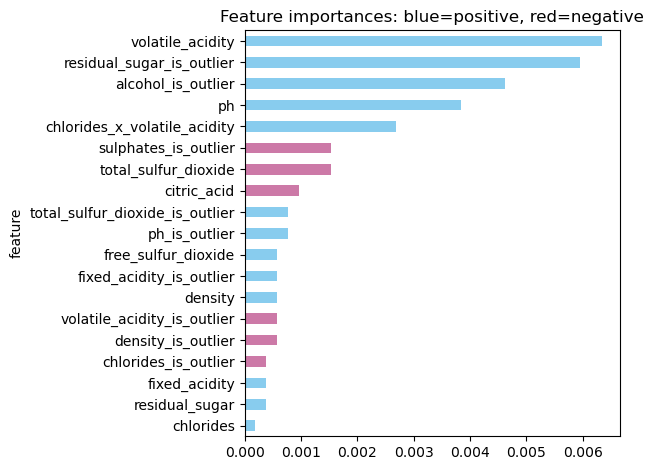

In [93]:
# Basline model
print(f"The number of features in X_train is {len(X_train.columns)}")
print(f"The number of features in X_val is {len(X_val.columns)}")
print("The most basic model, with engineered features: ")

## Modeling using Gaussian Naive Bayes - https://scikit-learn.org/stable/modules/naive_bayes.html
from sklearn.naive_bayes import GaussianNB
gnb_engineered = GaussianNB()
gnb_engineered = gnb_engineered.fit(X_train, y_train)
y_pred = gnb_engineered.predict(X_val)

print('confusion matrix:\n', confusion_matrix(y_val, y_pred))
print("The Model's Metrics:\n", classification_report(y_val, y_pred))

feature_importance = get_permutation_importance(gnb_engineered, X_train, X_val, y_val)
plot_feature_importance(feature_importance, show_sign_color=True, show_only_important=True)
# import prior model metrics
#model_metrics = pd.read_csv('model_metrics.csv', index_col=0)
# get current metrics

model=gnb_engineered
model_params=gnb_engineered.get_params()
model_name='baseline_engineered_features'
export_to_csv=True
model_metrics = get_model_metrics(y_val, y_pred, feature_importance,
                                  model=model, model_params=model_params,
                                  model_name=model_name)

print(model_metrics)

In [20]:
model_metrics

,model,hyper_parameters,"(support, 1)","(support, 0)",TP,FP,TN,FN,accuracy,"(distribution, 1)","(precision, 1)","(lift, 1)","(recall, 1)","(f1-score, 1)","(precision, 0)","(lift, 0)","(recall, 0)","(f1-score, 0)",feature_importance
baseline,GaussianNB(),"{'priors': None, 'var_smoothing': 1e-09}",204,836,157,312,524,47,0.654808,0.196154,0.334755,1.706593,0.769608,0.466568,0.917688,1.141622,0.626794,0.744847,"{'type_white': 0.037, 'chlorides': -0.024, 'fi..."
baseline_engineered_features,GaussianNB(),"{'priors': None, 'var_smoothing': 1e-09}",204,836,202,792,44,2,0.236538,0.196154,0.203219,1.036020,0.990196,0.337229,0.956522,1.189931,0.052632,0.099773,"{'volatile_acidity': 0.006, 'residual_sugar_is..."


In [21]:
model_metrics2

,model,hyper_parameters,"(support, 1)","(support, 0)",TP,FP,TN,FN,accuracy,"(distribution, 1)","(precision, 1)","(lift, 1)","(recall, 1)","(f1-score, 1)","(precision, 0)","(lift, 0)","(recall, 0)","(f1-score, 0)",feature_importance
baseline_engineered_features,GaussianNB(),"{'priors': None, 'var_smoothing': 1e-09}",204,836,202,792,44,2,0.236538,0.196154,0.203219,1.03602,0.990196,0.337229,0.956522,1.189931,0.052632,0.099773,"{'volatile_acidity': 0.006, 'residual_sugar_is..."


In [22]:
pd.concat([model_metrics, model_metrics2], axis=0)

,model,hyper_parameters,"(support, 1)","(support, 0)",TP,FP,TN,FN,accuracy,"(distribution, 1)","(precision, 1)","(lift, 1)","(recall, 1)","(f1-score, 1)","(precision, 0)","(lift, 0)","(recall, 0)","(f1-score, 0)",feature_importance
baseline,GaussianNB(),"{'priors': None, 'var_smoothing': 1e-09}",204,836,157,312,524,47,0.654808,0.196154,0.334755,1.706593,0.769608,0.466568,0.917688,1.141622,0.626794,0.744847,"{'type_white': 0.037, 'chlorides': -0.024, 'fi..."
baseline_engineered_features,GaussianNB(),"{'priors': None, 'var_smoothing': 1e-09}",204,836,202,792,44,2,0.236538,0.196154,0.203219,1.036020,0.990196,0.337229,0.956522,1.189931,0.052632,0.099773,"{'volatile_acidity': 0.006, 'residual_sugar_is..."
baseline_engineered_features,GaussianNB(),"{'priors': None, 'var_smoothing': 1e-09}",204,836,202,792,44,2,0.236538,0.196154,0.203219,1.036020,0.990196,0.337229,0.956522,1.189931,0.052632,0.099773,"{'volatile_acidity': 0.006, 'residual_sugar_is..."


In [23]:
gnb.get_params()

{'priors': None, 'var_smoothing': 1e-09}

In [24]:
gnb.score()

TypeError: ClassifierMixin.score() missing 2 required positional arguments: 'X' and 'y'

In [ ]:
str(gnb.__class__)

In [ ]:
model_metrics['model'] = [gnb]
model_metrics['hyper_parameters'] = [gnb.get_params()]
move_cols_to_first(model_metrics, ['model', 'hyper_parameters'])

In [ ]:
model_metrics['feature_importance'] = [feature_importance.round(2).to_dict()['importance']]
model_metrics['feature_importance']

In [ ]:
model_metrics['model']  = [gnb]
model_metrics

In [ ]:
dir(model_metrics['model'][0])

In [ ]:
conf_matrix = pd.DataFrame(confusion_matrix(y_val, y_pred))
conf_matrix = conf_matrix.stack().to_frame().T
conf_matrix.columns = ['TN','FP','FN','TP']
conf_matrix

In [ ]:

class_report

In [ ]:
class_report = pd.DataFrame(classification_report(y_val, y_pred, output_dict=True)).drop(columns=['macro avg', 'weighted avg'])
class_report = pd.concat([class_report[class_report.index=='support'], class_report[class_report.index!='support']], axis=0)
class_report = class_report.stack().to_frame().T
class_report = pd.concat([conf_matrix, class_report], axis=1)
class_report[[('support', '1'), ('support', '0')]] = class_report[[('support', '1'), ('support', '0')]].astype(int)
class_report[('distribution', '1')] = class_report[('support', '1')] / (class_report[('support', '0')] + class_report[('support', '1')])
class_report[('lift', '1')] = class_report[('precision', '1')] / class_report[('distribution', '1')]
class_report[('lift', '0')] = class_report[('precision', '0')] / (1-class_report[('distribution', '1')])
class_report = class_report.rename(columns={('support','accuracy'):'accuracy'}).drop(columns=[('f1-score','accuracy'),('recall','accuracy'), ('precision','accuracy')])
class_report = move_cols_to_first(class_report, [('support', '1'), ('support', '0'), 'TP', 'FP', 'TN', 'FN', 'accuracy', ('distribution', '1'), ('precision', '1'), ('lift', '1'), ('recall', '1'), ('f1-score', '1'), ('precision', '0'), ('lift', '0'), ('recall','0')])
class_report

In [ ]:
feature_importance

In [ ]:
feature_importance = get_permutation_importance(gnb, X_train_orig, X_val_orig, y_val)
feature_importance

# Let's model

In [26]:
model_metrics

,train_timestamp,model,hyper_parameters,"('support', '1')","('support', '0')",TP,FP,TN,FN,accuracy,"('distribution', '1')","('precision', '1')","('lift', '1')","('recall', '1')","('f1-score', '1')",AUC,"('precision', '0')","('lift', '0')","('recall', '0')","('f1-score', '0')",feature_importance
baseline,2023-07-16 09:12:45,GaussianNB(),"{'priors': None, 'var_smoothing': 1e-09}",204,836,157,312,524,47,0.654808,0.196154,0.334755,1.706593,0.769608,0.466568,0.756081,0.917688,1.141622,0.626794,0.744847,"{'type_white': 0.037, 'chlorides': -0.024, 'fi..."
baseline_engineered_features,2023-07-25 09:49:12,GaussianNB(),"{'priors': None, 'var_smoothing': 1e-09}",204,836,202,792,44,2,0.236538,0.196154,0.203219,1.036020,0.990196,0.337229,0.748156,0.956522,1.189931,0.052632,0.099773,"{'volatile_acidity': 0.006, 'residual_sugar_is..."


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import os

# Import data, set target
filename = "winequalityN.csv"
if filename in os.listdir():
    df = pd.read_csv(filename)
else:
    df = pd.read_csv("/usercode/" + filename)
target = 'quality'
df[target] = (df[target]>=7)*1

# Train-Test split
X = df.drop(columns=target)
y = df[[target]]
stratify = y # Make sure our split keep same distribution for our target in both train and test
test_size = 0.2 # each split will leave the test with 20% of the current data - it's is a common split ratio
shuffle = True # take random indexes of rows for each split, in case the data is not randomly sampled
random_state = 42 # use this specific random state - so we can reproduce our results if needed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=stratify, shuffle=shuffle, random_state=random_state)
stratify = y_train # The stratify split should change to the current target used
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=test_size, stratify=stratify, shuffle=shuffle, random_state=random_state)
# Validate outliers detection: Test if train outlier statistics are different than val outlier statistics
from scipy import stats
# Import the warnings module
import warnings

# Ignore the UserWarning from scipy.stats
# the warnings are saying we have less the 5000 samples so the noramlity test isn't accurate
warnings.filterwarnings("ignore", category=UserWarning, module="scipy.stats")

def test_if_significant(p_value, alpha=0.05, print_text=False):
    if p_value < alpha:
        if print_text:
            print(f"The means of the two populations are significantly different (alpha={alpha}).")
        return True
    else:
        if print_text:
            print("The means of the two populations are NOT significantly different (alpha={alpha}).")
        return False

def test_if_features_statistically_different(the_X_train, dfs_dict, alpha=0.05):
    '''Check if mean of numerical features in X_train and dfs_dict are statistically the same, for specified significance level
       return a df means, their difference and an answer the the question:
       Are the means statistically not different?'''
    # get train numeric features means
    train_val_outlier_means = the_X_train.describe().T.add_suffix('_train')['mean_train']
    for the_df_name, the_df in dfs_dict.items():
        # get other df numeric features means
        the_df_name = the_df_name.split("X_")[1]
        X_df_outlier_means = the_df.describe().T.add_suffix(f'_{the_df_name}')[f'mean_{the_df_name}']
        # concat the other df means to the same dataframe
        train_val_outlier_means = pd.concat([train_val_outlier_means, X_df_outlier_means], axis=1)
        # calc the mean for both, just to get a sense of the size of difference
        train_val_outlier_means['difference'] = (train_val_outlier_means['mean_train'] - train_val_outlier_means[f'mean_{the_df_name}']).round(3)
        for feature in train_val_outlier_means.index:
            # test the normality of the difference
            statatistic, p_value = stats.shapiro(the_X_train[feature] - the_df[feature])
            train_val_outlier_means.loc[feature, f'{the_df_name} difference is normal with {int((1-alpha)*100)}% significance'] = not test_if_significant(p_value, alpha=alpha)
            # perform the two-sample t-test for difference in means,
            t_statistic, p_value = stats.ttest_ind(the_X_train[feature], the_df[feature])
            train_val_outlier_means.loc[feature, f'{the_df_name} mean is the same with {int((1-alpha)*100)}% significance'] = not test_if_significant(p_value, alpha=alpha)
    return train_val_outlier_means

# Show all columns (don't replace some with "...")
pd.set_option('display.max_columns', None)
alpha = 0.01 # significance level
dfs_dict_to_test = {'X_val': X_val, 'X_test': X_test}
train_val_outlier_means_test = test_if_features_statistically_different(X_train, dfs_dict_to_test, alpha=alpha)
#print('\n# Test if train, validation and test sets means are statisically not different:\n', train_val_outlier_means_test)

# Missing Values imputation
# Create a variable to hold all train statistics,
# and insert the features with missing data, and transpose the matrix
train_statistics = X_train.describe(include='all').T
# Add a column to flag features with missing values
len_X_train = len(X_train)
train_statistics['has_na'] = (train_statistics['count'] < len_X_train)*1
statisticis_to_show = train_statistics.loc[train_statistics['has_na']==True, ['mean','has_na']]

# Create a function for missing values imputation, as we will imputate 3 times:
# for train, for valiation and for test
def imputate_missing_values(dataset_name, dataset, the_train_statistics, n_rows_to_show=5, add_print=True):
    # get a dict of missing values per each feature
    mean_values = the_train_statistics["mean"].to_dict()
    # impute missing values, and save those indexes
    missing_indexes = dataset[dataset.isna().any(axis=1)].index
    if add_print:
        to_show = dataset.loc[missing_indexes][:n_rows_to_show]
        print(f"# First {n_rows_to_show} original {dataset_name} missing values:\n{to_show}\n")
    # fill the missing values in X_train with the mean values
    dataset = dataset.fillna(value=mean_values)
    if add_print:
        to_show = dataset.loc[missing_indexes][:n_rows_to_show]
        print(f"# First {n_rows_to_show} imputed {dataset_name} missing values:\n{to_show}\n")
        missing_values = dataset.isna().sum()
        print(f"# The number of missing values in columns in {dataset_name}:\n{missing_values}\n")
    return dataset

# Impute missing values
X_train = imputate_missing_values('X_train', X_train, train_statistics, add_print=False)
X_val = imputate_missing_values('X_val', X_val, train_statistics, add_print=False)
X_test = imputate_missing_values('X_test', X_test, train_statistics, add_print=False)

def one_hot_encode_categoricals(the_df, categorical_features=['type'], drop_one=True, categories_to_use_from_train=None):
    # Create the numerical encodings
    one_hot_encodings = pd.get_dummies(the_df[categorical_features], drop_first=drop_one)
    # if val or test, filter categories to the ones that were used in train
    if categories_to_use_from_train:
        one_hot_encodings = one_hot_encodings[categories_to_use_from_train]
    one_hot_encodings_categories = one_hot_encodings.columns
    # Add the encodings to the dataset
    the_df = pd.concat([the_df, one_hot_encodings], axis=1)
    # Drop the original categorical_features
    the_df = the_df.drop(columns=categorical_features)
    return the_df, one_hot_encodings_categories

# Define parameters for the functions: cateorical features names, and if should one categoy be dropped for every feature
categorical_features=['type']
drop_one = True
# Encode categoricals for train, get back the train categories
X_train, train_categories = one_hot_encode_categoricals(X_train, categorical_features=categorical_features, drop_one=drop_one)

# Add new train cateogories statistics to train_statistics
def add_new_features_statistics_to_train_statistics(the_train, the_train_statistics, new_features):
    'Add new features statistics to train_statistics'
    train_new_features_statistics = the_train[new_features].describe(include='all').T
    the_train_statistics = pd.concat([the_train_statistics, train_new_features_statistics], axis=0)
    return the_train_statistics
train_statistics = add_new_features_statistics_to_train_statistics(X_train, train_statistics, train_categories)

def add_binary_property_to_train_statistics(the_train_statistics, the_property, features_list_with_property):
    "Add a binary property column (starting with 'is_') to group of features"
    if not the_property in train_statistics:
        the_train_statistics[the_property] = 0
    the_train_statistics.loc[features_list_with_property, the_property] = 1
    return the_train_statistics


# Add proprty 'is_categorical_to_drop' to original cateogorical features
train_statistics = add_binary_property_to_train_statistics(train_statistics, 'is_categorical_to_drop', categorical_features)
# Add proprty 'is_category' to newly created categories one-hot-encoding features
train_statistics = add_binary_property_to_train_statistics(train_statistics, 'is_category', train_categories)

def get_train_feautres_with_property(the_train_statistics, the_property):
    "Extract list of features with property from train_statistics"
    the_features = train_statistics[train_statistics[the_property]==1].index.tolist()
    return the_features


# Get category features and categories of train, from train_statistics
categorical_features = get_train_feautres_with_property(train_statistics, 'is_categorical_to_drop')
categories_to_use_from_train = get_train_feautres_with_property(train_statistics, 'is_category')
# Create a partial function, pre-set with these parameters, to be run on both X_val and X_test
from functools import partial
one_hot_encode_categoricals_fn = partial(one_hot_encode_categoricals, categorical_features=categorical_features, categories_to_use_from_train=categories_to_use_from_train)
X_val, _ = one_hot_encode_categoricals_fn(X_val)
X_test, _ = one_hot_encode_categoricals_fn(X_test)

# add kurtosis and skew statistics

from scipy.stats import kurtosis, skew

def add_kurtosis_skew_statistics(the_df, the_train_statistics):
    the_train_statistics['kurtosis'] = the_df.apply(kurtosis)
    the_train_statistics['skew'] = the_df.apply(skew)
    the_train_statistics['is_many_outliers'] = (the_train_statistics['kurtosis']>=3)*1
    the_train_statistics['is_right_skew'] = (the_train_statistics['skew']>0)*1
    return the_train_statistics

train_statistics = add_kurtosis_skew_statistics(X_train, train_statistics)

# Detect Outliers
def add_outlier_indicator(the_df: pd.DataFrame, the_feature: pd.Series, the_train_statistics: pd.DataFrame, outlier_col_suffix='is_outlier', is_train=False) -> pd.DataFrame:
    ''' Find outliers for given feature in df, mark outlier cells with 1, return new outlier columns'''
    outlier_col = the_feature + "_" + outlier_col_suffix
    # Create is_outlier col if it doesn't exist, and fill with 0 (i.e. no outliers)
    if not outlier_col in the_df:
        the_df[outlier_col] = 0
    # The formula for calculating a z-score is: Z = (X - μ) / σ
    X = the_df[the_feature]
    μ = the_train_statistics.loc[the_feature, 'mean']
    σ = the_train_statistics.loc[the_feature, 'std']
    obs_z_scores = (X - μ)/σ
    # Get all rows with outliers
    outliers = obs_z_scores.abs() > 3
    # Mark outliers
    if sum(outliers) > 0:
        the_df.loc[outliers, outlier_col] = 1
    else:
        if is_train: # if train and no outliers, drop column. if val or test, keep zeros.
            the_df = the_df.drop(columns=outlier_col)

    return the_df, outlier_col

from typing import List

def add_outlier_indicators_on_features(the_df: pd.DataFrame, the_train_statistics: pd.DataFrame, X_train_numeric_features: List = None, outlier_col_suffix='is_outlier') -> pd.DataFrame:
    ''' If the_features=None, assume train and find outliers for all numeric features
        If the_features=[given list], assume val or test and find outliers on specific columns
        return dataset with new outlier columns and 0/1 indicators for outlier cells
    '''
    # If the_features not defined (first run on train), filter out non-numeric features and run on all
    if not X_train_numeric_features:
        is_train = True
        categories = get_train_feautres_with_property(train_statistics, 'is_category')
        X_train_numeric_features = [col for col in X_train.columns if not col in categories]
    else:
        is_train = False # either validation or test
    new_outlier_cols = []
    for feature in X_train_numeric_features:
        the_df, new_outlier_col = add_outlier_indicator(the_df, feature, the_train_statistics, outlier_col_suffix=outlier_col_suffix, is_train=is_train)
        new_outlier_cols = new_outlier_cols + [new_outlier_col]
    return the_df, new_outlier_cols


# Add outlier column indicator, having 1 for outlier rows
X_train_numeric_features = None # When none, assume train dataset and find all relevent columns
outlier_col_suffix = 'is_outlier'
X_train, train_outiler_cols = add_outlier_indicators_on_features(X_train, train_statistics, X_train_numeric_features=X_train_numeric_features, outlier_col_suffix=outlier_col_suffix)

# Update outlier statistics to train_statistics
train_statistics = add_new_features_statistics_to_train_statistics(X_train, train_statistics, train_outiler_cols)
#print("# Updated train_statistics: \n", train_statistics)

## Apply outlier indicators on validation and test
def get_train_features_with_suffix(the_train_statistics, remove_suffix=True, the_suffix='is_outlier'):
    the_train_statistics_features = the_train_statistics.index.to_list()
    feautres_with_suffix = [feature for feature in the_train_statistics_features if feature.endswith(the_suffix)]
    if remove_suffix:
        feautres_with_suffix = [feature.split("_"+the_suffix)[0] for feature in feautres_with_suffix]
    return feautres_with_suffix
# get train outlier columns
train_outiler_cols = get_train_features_with_suffix(train_statistics, the_suffix=outlier_col_suffix)
# Add outlier indicators to val and test in those specific features
add_outlier_indicators_on_features_fn = partial(add_outlier_indicators_on_features, the_train_statistics=train_statistics, X_train_numeric_features=train_outiler_cols, outlier_col_suffix=outlier_col_suffix)
X_val, _ = add_outlier_indicators_on_features_fn(X_val)
X_test, _ = add_outlier_indicators_on_features_fn(X_test)

# Validate outliers detection: Test if train outlier statistics are different than val outlier statistics
remove_suffix=False
train_outlier_cols = get_train_features_with_suffix(train_statistics, the_suffix=outlier_col_suffix, remove_suffix=remove_suffix)
remove_suffix=True
train_orig_outlier_cols = get_train_features_with_suffix(train_statistics, the_suffix=outlier_col_suffix, remove_suffix=remove_suffix)
#X_train_outliers = X_train.loc[(X_train[train_outlier_cols]==1).any(axis=1), train_orig_outlier_cols]
#X_val_outliers = X_val.loc[(X_val[train_outlier_cols]==1).any(axis=1), train_orig_outlier_cols]
#print(f"\n# The train outliers:\n {X_train_outliers}")
#alpha = 0.01 # significance level
#dfs_dict_to_test = {'X_val_outliers': X_val_outliers}
#train_val_outlier_means_test = test_if_features_statistically_different(X_train_outliers, dfs_dict_to_test, alpha=alpha)
#print('\n# Test if train and validation outliers means are statisically not different:\n', train_val_outlier_means_test)

# Impute outliers features

def add_winsorization_values_to_train_statistics(the_X_train, the_train_statistics, percentiles=[.05,.95]):
    '''Add percentile data to train_statistics, to later be used for winsorization'''
    winsorization_values = the_X_train.describe(include='all', percentiles=[.05,.95]).T
    percentile_col_names = [str(col).split(".")[1].replace("0","")+"%" for col in percentiles]
    the_train_statistics = pd.concat([the_train_statistics, winsorization_values[percentile_col_names]],axis=1)
    return the_train_statistics

def winsorize_outliers(the_df, the_train_statistics, percentiles=[.05,.95]):
    # extract original outlier call and is_outliers cols
    remove_suffix=False
    train_outlier_cols = get_train_features_with_suffix(train_statistics, the_suffix=outlier_col_suffix, remove_suffix=remove_suffix)
    remove_suffix=True
    train_orig_outlier_cols = get_train_features_with_suffix(train_statistics, the_suffix=outlier_col_suffix, remove_suffix=remove_suffix)
    outlier_cols_mapper = dict(zip(train_orig_outlier_cols, train_outlier_cols))
    # extract winsorization values
    percentile_col_names = [str(col).split(".")[1].replace("0","")+"%" for col in percentiles]
    winsorization_values = the_train_statistics.loc[train_orig_outlier_cols, percentile_col_names].T
    # replace min/max outliers with min_winzor/max_winzor
    for orig_col, is_outlier_col in outlier_cols_mapper.items():
        min_winzor = winsorization_values[orig_col].min()
        max_winzor = winsorization_values[orig_col].max()
        outlier_rows = the_df[is_outlier_col]==1
        min_outliers = the_df[orig_col]<=min_winzor
        max_outliers = the_df[orig_col]>=max_winzor
        the_df.loc[(outlier_rows)&(min_outliers),orig_col] = min_winzor
        the_df.loc[(outlier_rows)&(max_outliers),orig_col] = max_winzor

    return the_df

train_statistics = add_winsorization_values_to_train_statistics(X_train, train_statistics)
#print("# Updated train_statistics: \n", train_statistics)

X_train = winsorize_outliers(X_train, train_statistics)
X_val = winsorize_outliers(X_val, train_statistics)
X_test = winsorize_outliers(X_test, train_statistics)

#X_train_outliers_mean = X_train.loc[(X_train[train_outlier_cols]==1).any(axis=1), train_orig_outlier_cols].mean().rename("Outlier rows means")
#X_train_imputed_outliers_mean = X_train.loc[(X_train[train_outlier_cols]==1).any(axis=1), train_orig_outlier_cols].mean().rename("Imputed outlier rows means")
#X_train_imputed_outliers_mean = pd.concat([X_train_outliers_mean, X_train_imputed_outliers_mean], axis=1)
#print(f"\n# See how the means of the outliers rows changed after the imputations:\n {X_train_imputed_outliers_mean}")
#print(train[X_train[train_outlier_cols]==1])
#print(X_train)

# Engineer new features

def add_polynomial_features(the_df, features_to_add=None, suffix='_squared'):
    'For each feature in features_to_quare, add the_df the power of 2 of that feature'
    if features_to_add is None:
        features_to_add = ['alcohol','density']
    new_features_list = []
    for feature in features_to_add:
        new_feature = feature + suffix
        the_df[new_feature] = the_df[feature] ** 2
        new_features_list = new_features_list + [new_feature]
    return the_df, new_features_list

def add_combination_features(the_df, features_to_add=None):
    'For each feature in features_to_add, add the_df the result of the formula of that feature'
    if features_to_add is None:
        features_to_add = ['total acidity', 'combined sulfur dioxide', 'mso2']
    new_features_list = features_to_add
    for feature in features_to_add:
        if feature == 'total acidity':
            the_df[feature] = the_df['fixed acidity'] + the_df['volatile acidity']
        if feature == 'combined sulfur dioxide':
            the_df[feature] = the_df['total sulfur dioxide'] - the_df['free sulfur dioxide']
        if feature == 'mso2':
            the_df[feature] = (1+10**(the_df['pH']-1.81))
    return the_df, new_features_list

def add_interaction_features(the_df, features_tuples_list_to_add=None):
    'For each pair of features in features_tuples_list_to_add, add the_df the multiplication of the features'
    if features_tuples_list_to_add is None:
        features_tuples_list_to_add = [ ('total sulfur dioxide', 'alcohol'),
                                        ('chlorides','volatile acidity'),
                                        ('density','citric acid')
                                        ]
    new_features_list = []
    for feature1, feature2  in features_tuples_list_to_add:
        new_feature = feature1 + "_X_" + feature2
        the_df[new_feature] = the_df[feature1] * the_df[feature2]
        new_features_list = new_features_list + [new_feature]
    return the_df, new_features_list

def add_ratio_features(the_df, features_tuples_list_to_add=None):
    'For each pair of features in features_tuples_list_to_add, add the_df the ration of the features'
    if features_tuples_list_to_add is None:
        features_tuples_list_to_add = [ ('total acidity', 'free sulfur dioxide'),
                                        ('free sulfur dioxide','total sulfur dioxide'),
                                        ('total acidity','pH'),
                                        ('citric acid','fixed acidity'),
                                        ('alcohol','density'),
                                        ('residual sugar','chlorides'),
                                        ]
    new_features_list = []
    for feature1, feature2  in features_tuples_list_to_add:
        new_feature = feature1 + "_/_" + feature2
        the_df[new_feature] = the_df[feature1] / the_df[feature2]
        new_features_list = new_features_list + [new_feature]
    return the_df, new_features_list


def engineer_new_features(the_df, add_functions_list=None, features_to_add_list=None):
    'For each adding function and features to add, apply the function on the_df'
    if add_functions_list is None:
        add_functions_list = [add_polynomial_features,
                              add_combination_features,
                              add_interaction_features,
                              add_ratio_features]
    if features_to_add_list is None:
        features_to_add_list = [None,
                                None,
                                None,
                                None]
    new_features_list = []
    for a_func, features_to_add in zip(add_functions_list, features_to_add_list):
        the_df, func_new_features_list = a_func(the_df, features_to_add)
        new_features_list = new_features_list + func_new_features_list
    return the_df, new_features_list


X_train, new_features_list = engineer_new_features(X_train)
X_val, _ = engineer_new_features(X_val)
X_test, _ = engineer_new_features(X_test)
#print('# X_train new engineered features:\n', X_train[new_features_list])
train_statistics = add_new_features_statistics_to_train_statistics(X_train, train_statistics, new_features_list)
train_statistics = add_binary_property_to_train_statistics(train_statistics, 'is_engineered', new_features_list)
train_statistics = add_binary_property_to_train_statistics(train_statistics, 'is_engineered', [feature+"_is_outlier" for feature in train_outiler_cols]) # outlier features are also engineered
#print("\n# Updated train_statistics: \n", train_statistics)
n_new_features = train_statistics['is_engineered'].sum()
#print(f"\n# Including outliers, we have succuesfully created {n_new_features} new engineered features!")


# Drop highly correlated features

def get_multicollinear_features(features_list, df_multicollinear_corr, add_print=False):
    """using a correlatin matrix df_multicollinear_corr and a list of features to test,
    return a list of highly correlated features (compared to the list of features to test)"""
    multicollinear_feautres = {}
    for feature in features_list:
        feature_val_counts = df_multicollinear_corr[feature].value_counts()
        if len(feature_val_counts)>0:
            features_high_corr = df_multicollinear_corr[feature].dropna()
            if add_print:
                print(f"\n{features_high_corr}")
            multicollinear_feautres[feature] = features_high_corr.index.tolist()
    engineered_correlated_feautures = pd.DataFrame.from_dict(multicollinear_feautres, orient='index').reset_index().drop(columns='index').stack().drop_duplicates().values
    return engineered_correlated_feautures


def drop_high_correlation_features(the_df, the_train_statistics, method='pearson', high_corrleation_threshold=0.9, add_print=False):
    if add_print:
        print(f"\n# Each feature's high pearson correlations (at least {high_corrleation_threshold}):")
    df_corr = the_df.corr(method='pearson')
    # Get all high correlations features' sets
    df_corr = df_corr[(df_corr.abs()>=high_corrleation_threshold)&(df_corr.abs()!=1)].dropna(how='all')
    # get engineered highly correlated features
    orig_features = the_train_statistics[the_train_statistics['is_engineered'] == 0].index
    orig_features = [col for col in orig_features if col in df_corr]
    engineered_correlated_feautures = get_multicollinear_features(orig_features, df_corr, add_print=add_print)
    if add_print:
        print(f"\nThere are {len(engineered_correlated_feautures)} high correlated engineered feautres (>={high_corrleation_threshold}):\n{engineered_correlated_feautures}")
    # drop engineered highly correlated features
    the_df = the_df.drop(columns=engineered_correlated_feautures)
    if add_print:
        print(f"After dropping highly correlated engineered features (>={high_corrleation_threshold}, there are {len(the_df.columns)} features in dataset")
    all_correlated_dropped_features = engineered_correlated_feautures
    # get remaining highly correlated features
    remaining_features = the_train_statistics[the_train_statistics['is_engineered'] == 1].index
    remaining_features = [col for col in remaining_features if col in df_corr if col in the_df]
    remaining_correlated_feautures = get_multicollinear_features(remaining_features, df_corr, add_print=add_print)
    if add_print:
        print(f"There are {len(remaining_correlated_feautures)} high correlated remaining feautres (>={high_corrleation_threshold}):\n{remaining_correlated_feautures}")
    if len(remaining_correlated_feautures)>0:
        # drop remaining highly correlated features
        the_df = the_df.drop(columns=remaining_correlated_feautures)
        if add_print:
            print(f"After dropping highly correlated remaining features (>={high_corrleation_threshold}, there are {len(the_df.columns)} features in dataset")
        all_correlated_dropped_features = all_correlated_dropped_features + remaining_correlated_feautures
    return the_df, all_correlated_dropped_features

add_print=False
X_train, correlated_dropped_features = drop_high_correlation_features(X_train, train_statistics, method='pearson', high_corrleation_threshold=0.9, add_print=add_print)
train_statistics = add_binary_property_to_train_statistics(train_statistics, 'is_correlated_to_drop', correlated_dropped_features)
correlated_dropped_features = get_train_feautres_with_property(train_statistics, 'is_correlated_to_drop')
X_val = X_val.drop(columns=correlated_dropped_features)
X_test = X_test.drop(columns=correlated_dropped_features)

#print(f"\n# Updated X_train after highly correalted features dropped:\n{X_train}")

#print(f"\n# Current correlations in X_train:\n{X_train.corr()}")

# Normalize dataset

def standardize_df_using_train_statistics(the_df, the_train_statistics, add_print=False):
    for feature in the_df:
        μ = the_train_statistics.loc[the_train_statistics.index==feature, 'mean'].values
        σ = the_train_statistics.loc[the_train_statistics.index==feature, 'std'].values
        the_df[feature] = (the_df[feature] - μ) / σ
    if add_print:
        print("\n # The standardized features means and standard deviations:\n")
        print(the_df.agg(['mean','std']).round(3))
    return the_df

# Update train_statistics with current X_train mean and std
train_statistics['mean'] = X_train.mean().T
train_statistics['std'] = X_train.std().T
# standardize train, validation and test
add_print=False
X_train = standardize_df_using_train_statistics(X_train, train_statistics, add_print=add_print)
add_print=False
X_val = standardize_df_using_train_statistics(X_val, train_statistics, add_print=add_print)
X_test = standardize_df_using_train_statistics(X_test, train_statistics, add_print=add_print)

#print("\n # The new standardized train set:\n")
#print(X_train)

# Balance Target

def upsample_target_minority(the_df, the_train_statistics, random_state=42):
    """Upsample target minority so that the target classes will be balacned, return feature and target seperately"""
    # Extract target name from train_statistics
    target = the_train_statistics[the_train_statistics['is_target']==1].index[0]
    # get the number of rows of majority class and the classes values
    target_mean = the_train_statistics.loc[the_train_statistics.index==target, 'mean'][0]
    if target_mean>=0.5:
        majority_pct = target_mean
        minority_class = 0
        majority_class = 1
    else:
        majority_pct =  1 - target_mean
        minority_class = 1
        majority_class = 0

    df_size = len(the_df)
    majority_N_rows = int(np.floor(majority_pct*df_size))
    # Resample the minorty class (with replacemnt) to the number of rows in majority class
    the_df_minorty = the_df[the_df[target]==minority_class]
    the_df_majority = the_df[the_df[target]==majority_class]
    the_df_minorty = the_df_minorty.sample(majority_N_rows, random_state=random_state, replace=True)
    # Concat the rows back together, and shuffle the df
    the_df = pd.concat([the_df_minorty, the_df_majority], axis=0)
    the_df = the_df.sample(frac=1)
    # split the features and the target to two dfs
    the_target_df = the_df[target]
    the_target_features = the_df.drop(columns=target)
    return the_target_features, the_target_df

def add_target_to_train_statistics(the_train_target, the_train_statistics, target='quality'):
    # get target statistics
    target_statistics = the_train_target.describe(include='all').T
    # add target statistics to train statistics
    the_train_statistics = pd.concat([target_statistics, the_train_statistics], axis=0)
    # add is_target property
    the_train_statistics = add_binary_property_to_train_statistics(the_train_statistics, 'is_target', target)
    # move is_target property to first column
    the_train_statistics = pd.concat([the_train_statistics['is_target'], the_train_statistics.drop(columns=['is_target'])], axis=1)
    return the_train_statistics

# Update train statistics with the target distribution and mark
train_statistics = add_target_to_train_statistics(y_train, train_statistics, target)

# Concatenate the feature with the target before upsampling
train = pd.concat([X_train, y_train], axis=1)
val = pd.concat([X_val, y_val], axis=1)

upsample_target_minority_fn = partial(upsample_target_minority, the_train_statistics=train_statistics, random_state=42)
X_train, y_train = upsample_target_minority_fn(train)
#print(f"\n# After upsampling, the current train target distribution is:\n{y_train.value_counts(normalize=False, dropna=False)}")

# final preprocessing
def replace_columns_spaces_with_underscores(the_df):
    the_df.columns = the_df.columns.str.replace("_/_","/")
    the_df.columns = the_df.columns.str.replace(" ","_")
    return the_df

def drop_features(the_df, features_to_drop, errors='ignore'):
    the_df = the_df.drop(columns=features_to_drop, errors=errors)
    return the_df

def drop_features_with_train_statistics_property(the_df, the_train_statistics, property_list, errors='ignore'):
    ## drop categorical already-encoded features, and highly correlated features:
    for type_of_features_to_drop in property_list:
        features_to_drop = get_train_feautres_with_property(train_statistics, type_of_features_to_drop)
        the_df = drop_features(the_df, features_to_drop=features_to_drop, errors=errors)
    return the_df

types_of_features_to_drop = ['is_categorical_to_drop', 'is_correlated_to_drop']
dropping_errors = 'ignore' # don't report if feature is missing
## drop highly correlated features:
drop_features_with_train_statistics_property_fn = partial(
    drop_features_with_train_statistics_property, the_train_statistics=train_statistics,
    property_list=types_of_features_to_drop, errors=dropping_errors)

# fix columns names
X_train = replace_columns_spaces_with_underscores(X_train)
X_val = replace_columns_spaces_with_underscores(X_val)
X_test = replace_columns_spaces_with_underscores(X_test)
train_statistics = replace_columns_spaces_with_underscores(train_statistics.T).T

## confusion matrix

from sklearn.metrics import confusion_matrix, classification_report

def move_cols_to_first(the_df, cols):
    other_cols = the_df.columns[~the_df.columns.isin(cols)]
    the_df = pd.concat([the_df[cols],the_df[other_cols]],axis=1)
    return the_df


## Feature importance

from sklearn.inspection import permutation_importance
from sklearn.feature_extraction.text import CountVectorizer

def reorder_feature_importance_by_abs_values(the_feature_importance, importance_col='importance'):
    feature_importance_index = the_feature_importance.copy(deep=True).abs().sort_values(by=importance_col, ascending=False).index
    the_feature_importance = the_feature_importance.loc[feature_importance_index]
    return the_feature_importance

def get_permutation_importance(the_model, the_X_train, the_X_val, the_y_val, random_state=0):
    imps = permutation_importance(the_model, the_X_val.values, the_y_val.values, random_state=random_state)
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(the_X_train)
    feature_names = count_vect.get_feature_names_out()
    the_feature_importance = zip(feature_names, imps.importances_mean)
    the_feature_importance = sorted(the_feature_importance, key=lambda x: x[1], reverse=True)
    the_feature_importance = pd.DataFrame(the_feature_importance)
    the_feature_importance.columns = ['feature','importance']
    the_feature_importance = the_feature_importance.set_index('feature')
    the_feature_importance = reorder_feature_importance_by_abs_values(the_feature_importance, importance_col='importance')
    return the_feature_importance

def plot_feature_importance(the_feature_importance, show_sign_color=True, show_only_important=True, model_name=""):
    the_feature_importance = the_feature_importance.copy(deep=True)
    # Color-blind friendly colors - #88CCEE” (light blue), #CC79A7” (reddish purple)
    if show_sign_color:
        the_feature_importance['color'] = np.where(the_feature_importance['importance'] >= 0, '#88CCEE', '#CC79A7')
        the_feature_importance['importance'] = the_feature_importance['importance'].abs()
    the_feature_importance = the_feature_importance.sort_values(by='importance', ascending=True)
    if show_only_important:
        the_feature_importance = the_feature_importance[the_feature_importance['importance']>0]
    if show_sign_color:
        the_feature_importance['importance'].plot.barh(color=the_feature_importance['color'].values, title=f'{model_name} Feature importances: blue=positive, red=negative')
    else:
        the_feature_importance['importance'].plot.barh(title=f'{model_name} Feature importances')
    plt.tight_layout()

from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay

def plot_roc_curves(the_y_train, the_y_prob_train, the_y_val, the_y_prob_val, model_name='basline'):
    # Compute the FPR and TPR for different thresholds for both train and validation sets
    fpr_train, tpr_train, thresholds_train = roc_curve(the_y_train, the_y_prob_train)
    fpr_val, tpr_val, thresholds_val = roc_curve(the_y_val, the_y_prob_val)

    # Compute the AUC score for both train and validation sets
    auc_train = roc_auc_score(the_y_train, the_y_prob_train)
    auc_val = roc_auc_score(the_y_val, the_y_prob_val)

    # Create a figure and an axis object
    fig, ax = plt.subplots()

    # Plot the ROC curve for both train and validation sets using RocCurveDisplay
    RocCurveDisplay(fpr=fpr_train, tpr=tpr_train, roc_auc=auc_train, estimator_name='Train').plot(ax=ax)
    RocCurveDisplay(fpr=fpr_val, tpr=tpr_val, roc_auc=auc_val, estimator_name='Validation').plot(ax=ax)

    ax.set_title(f"{model_name} ROC curve".capitalize())
    # Plot the y=x dotted line
    plt.plot([0, 1], [0, 1], 'r--', label='Random classifier')
    plt.legend(loc='lower right')
    # Show the plot
    plt.show()


import os
from datetime import datetime

def get_model_metrics(the_y_val, the_y_pred, the_y_prob_val, the_feature_importance, model, model_params, model_name='baseline', existing_model_metrics=None, export_to_csv=False):
    # if not existing_model_metrics, import existing metrics from folder if it exists, else create a new dataframe.
    # if existing_model_metrics - use the existing model metrics, in the end we'll append current results to existing.
    if existing_model_metrics is None:
        if 'model_metrics.csv' in os.listdir():
            the_model_metrics = pd.read_csv('model_metrics.csv', index_col=0)
        else:
            the_model_metrics = pd.DataFrame()
    else:
        the_model_metrics = existing_model_metrics.copy(deep=True)
    # create confusion matrix
    conf_matrix = pd.DataFrame(confusion_matrix(the_y_val, the_y_pred))
    conf_matrix = conf_matrix.stack().to_frame().T
    conf_matrix.columns = ['TN','FP','FN','TP']
    # create classification report
    class_report = pd.DataFrame(classification_report(the_y_val, the_y_pred, output_dict=True)).drop(columns=['macro avg', 'weighted avg'])
    class_report = pd.concat([class_report[class_report.index=='support'], class_report[class_report.index!='support']], axis=0)
    class_report = class_report.stack().to_frame().T
    class_report = pd.concat([conf_matrix, class_report], axis=1)
    class_report[[('support', '1'), ('support', '0')]] = class_report[[('support', '1'), ('support', '0')]].astype(int)
    ## create distribution 1, lift 1, lift 0
    class_report[('distribution', '1')] = class_report[('support', '1')] / (class_report[('support', '0')] + class_report[('support', '1')])
    class_report[('lift', '1')] = class_report[('precision', '1')] / class_report[('distribution', '1')]
    class_report[('lift', '0')] = class_report[('precision', '0')] / (1-class_report[('distribution', '1')])
    class_report = class_report.rename(columns={('support','accuracy'):'accuracy'}).drop(columns=[('f1-score','accuracy'),('recall','accuracy'), ('precision','accuracy')])
    ## add AUC
    class_report['AUC'] = roc_auc_score(the_y_val, the_y_prob_val)
    ## reorder columns
    class_report = move_cols_to_first(class_report, [('support', '1'), ('support', '0'), 'TP', 'FP', 'TN', 'FN', 'accuracy', ('distribution', '1'), ('precision', '1'), ('lift', '1'), ('recall', '1'), ('f1-score', '1'), 'AUC', ('precision', '0'), ('lift', '0'), ('recall','0')])
    # add feature importance
    the_feature_importance = the_feature_importance if isinstance(model_name, dict) else the_feature_importance.round(3).to_dict()['importance']
    class_report['feature_importance'] = [the_feature_importance]
    # add modeling metdata
    class_report['model'] = [model]
    class_report['hyper_parameters'] = [model_params]
    class_report['train_timestamp'] = pd.to_datetime(datetime.now().strftime("%d-%m-%Y %H:%M:%S"), dayfirst=True)
    class_report = move_cols_to_first(class_report, ['train_timestamp','model', 'hyper_parameters'])
    # set model name
    model_name = model_name if isinstance(model_name, list) else [model_name]
    class_report.index = model_name
    # append current results to either new or existing dataframe
    if len(the_model_metrics)>0:
        class_report.columns = the_model_metrics.columns
    the_model_metrics = pd.concat([the_model_metrics, class_report], axis=0)
    if export_to_csv:
        the_model_metrics.to_csv('model_metrics.csv')
    return the_model_metrics



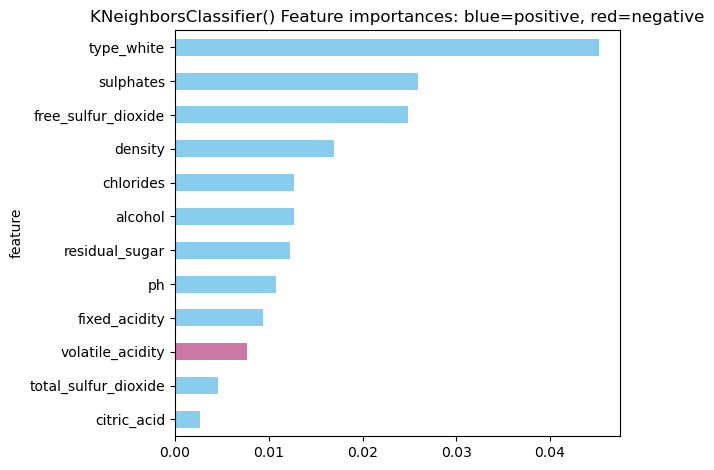

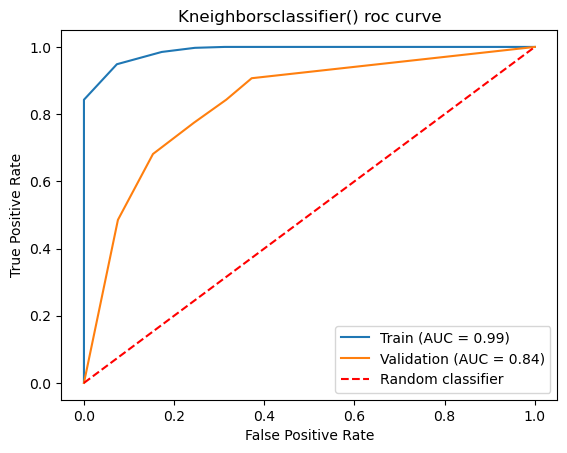

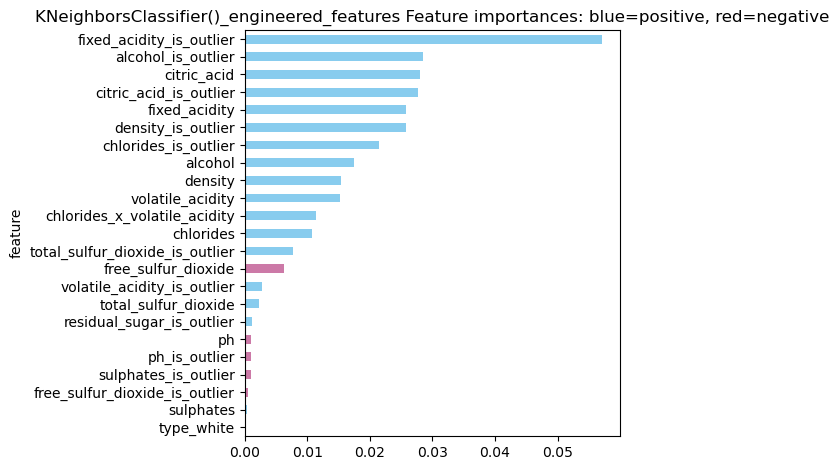

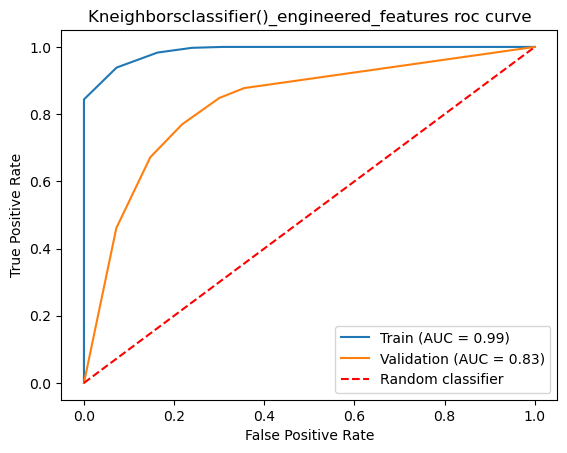

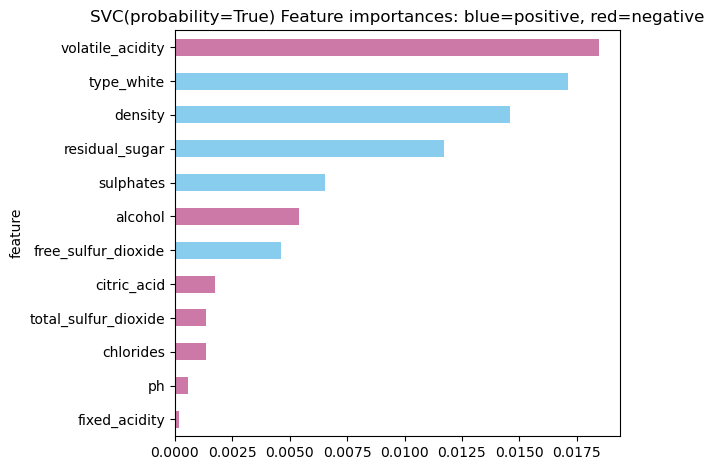

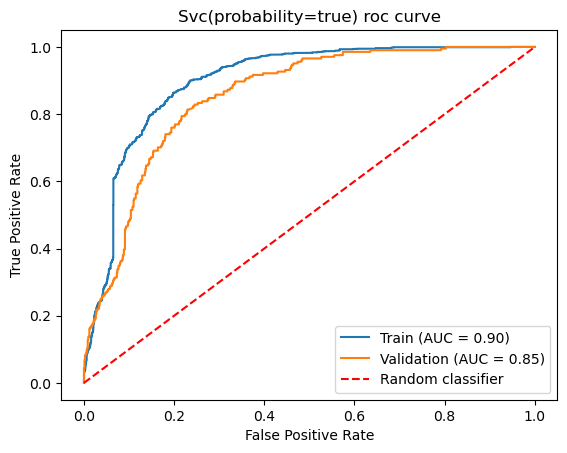

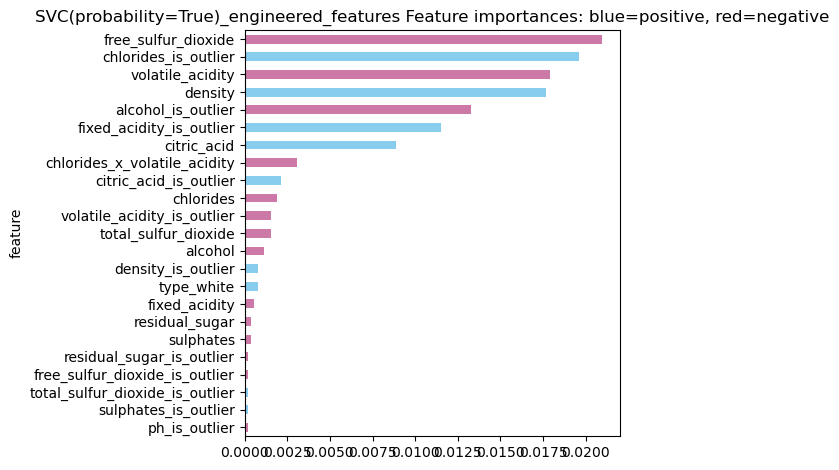

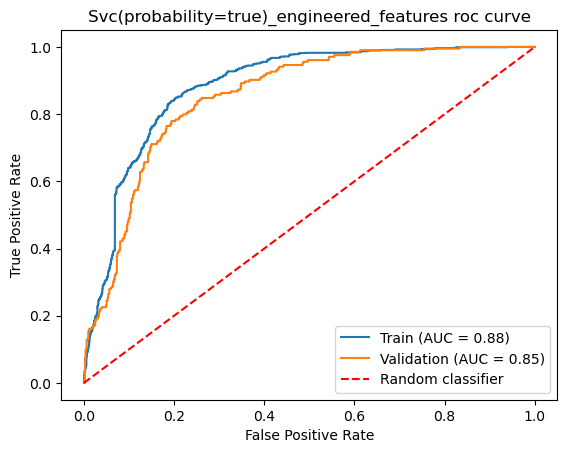

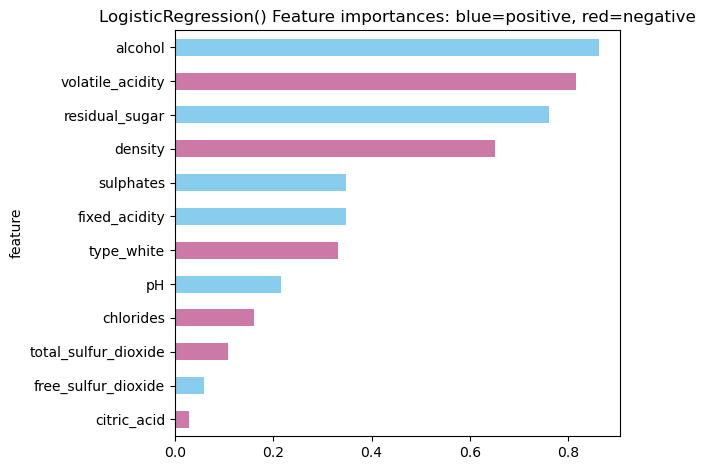

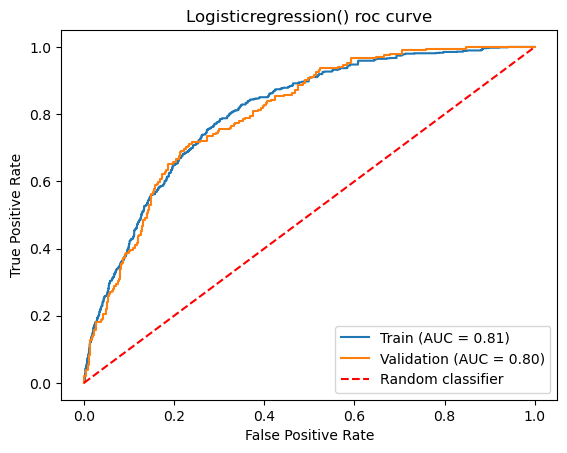

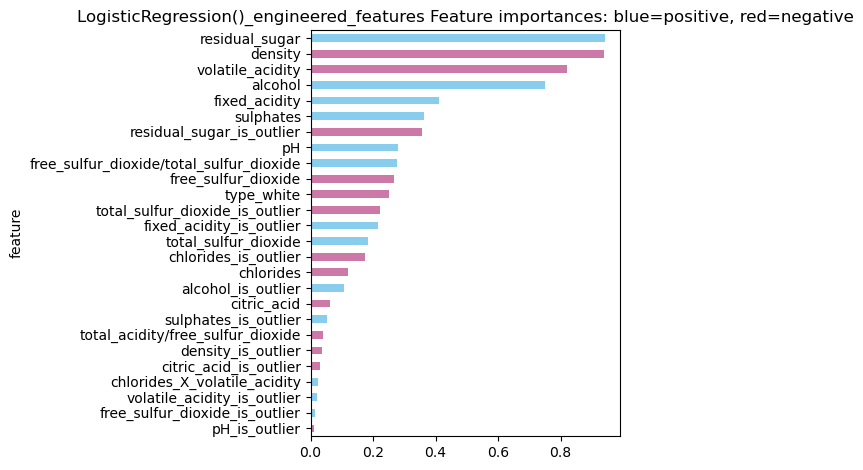

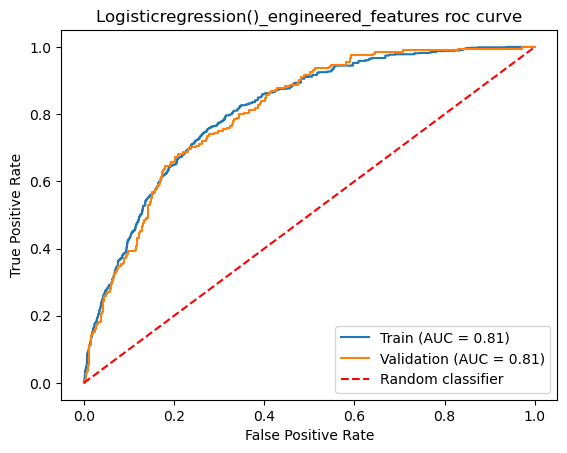

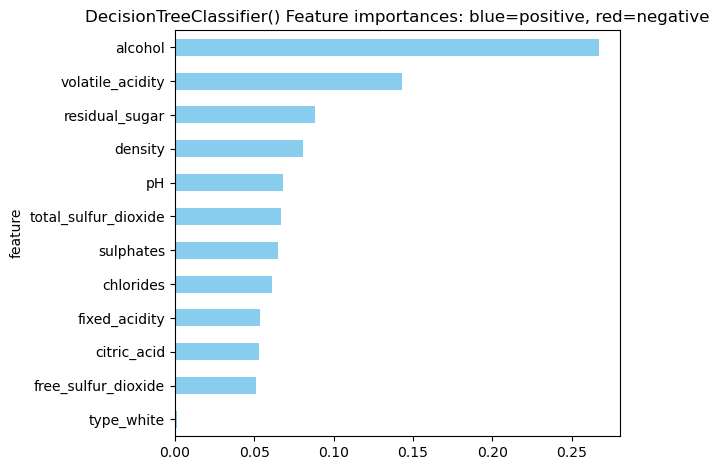

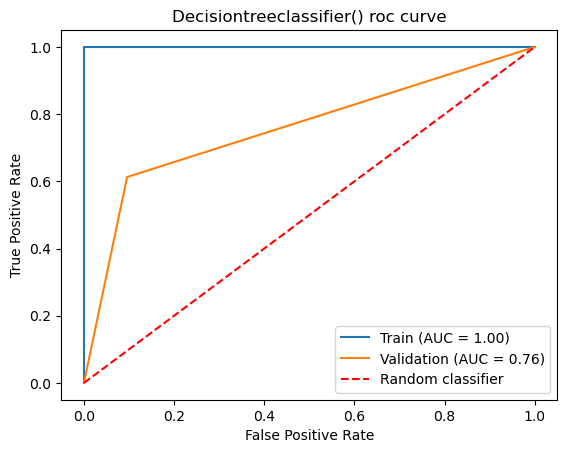

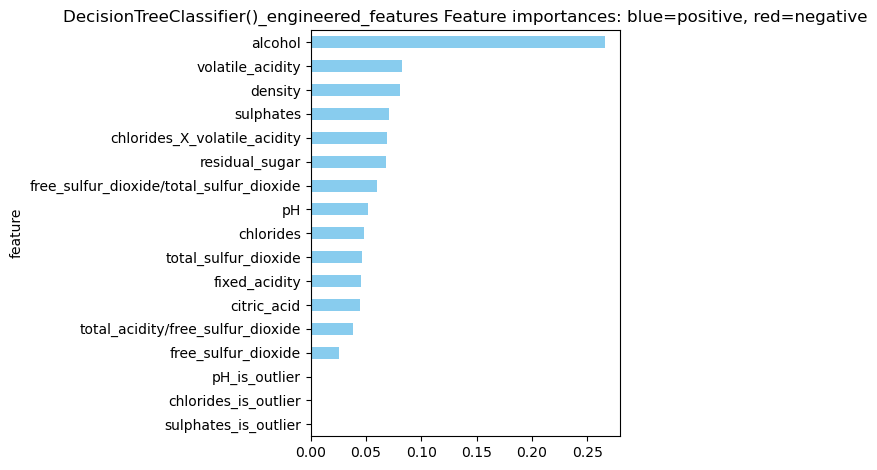

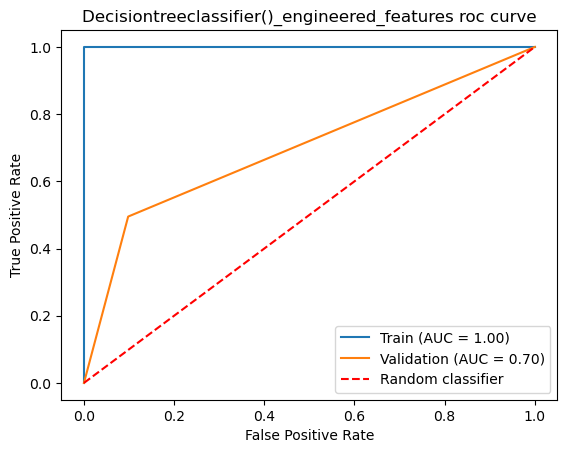

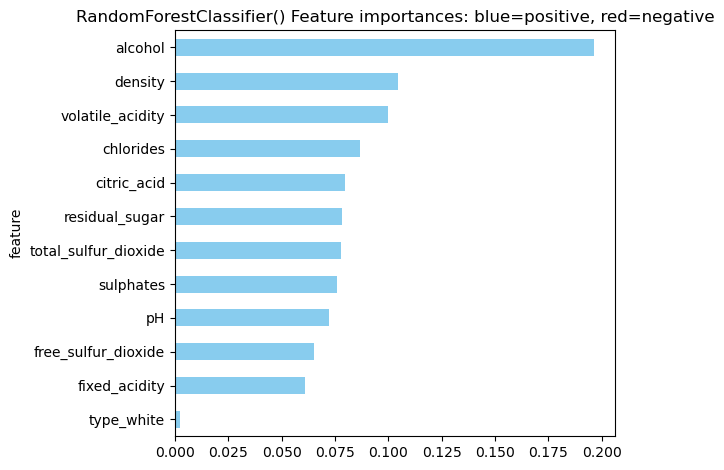

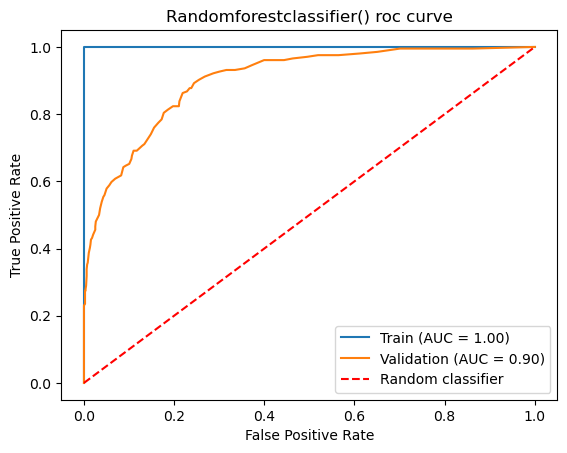

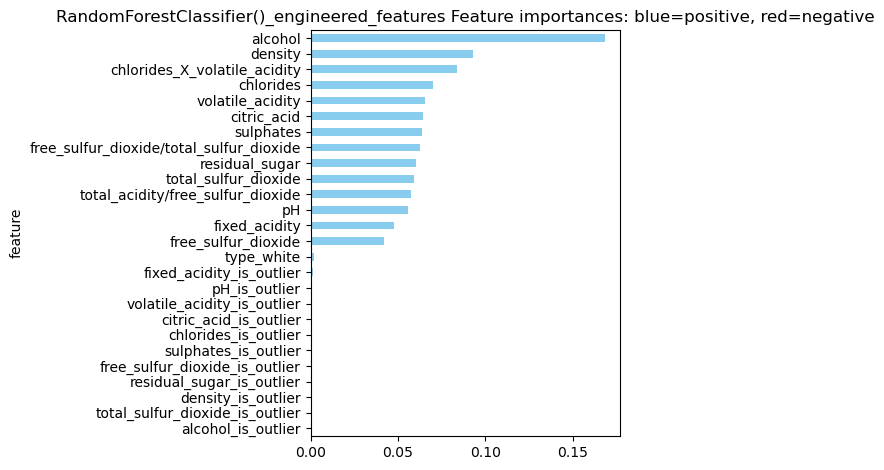

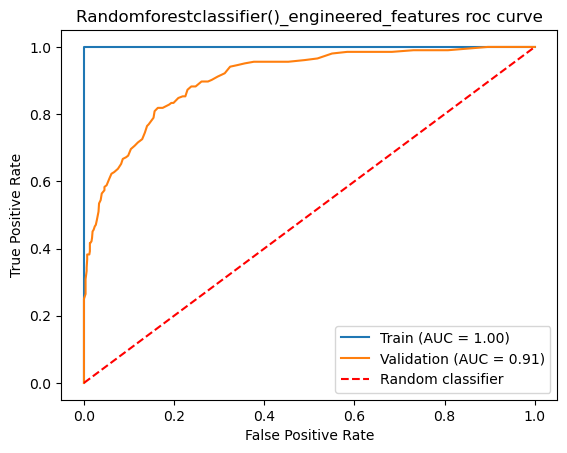

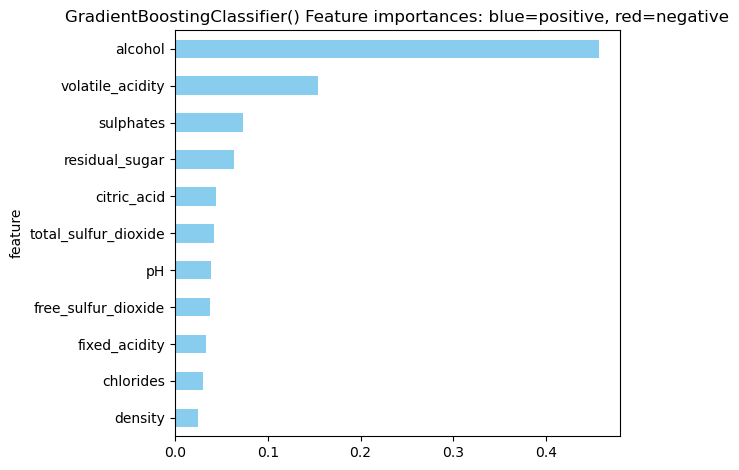

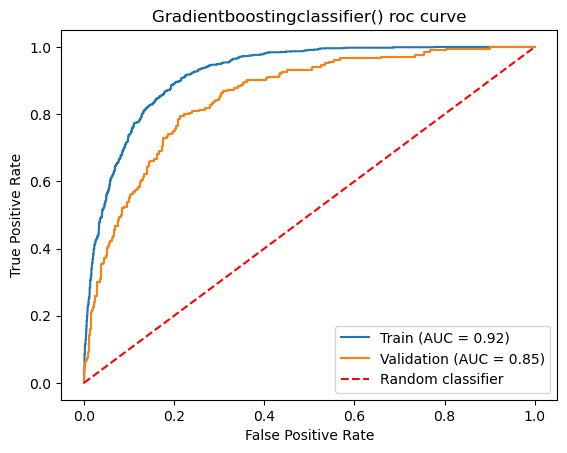

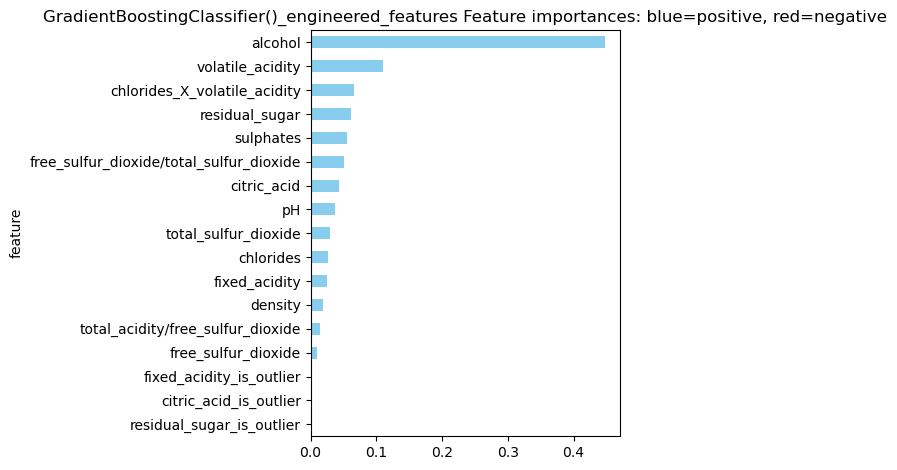

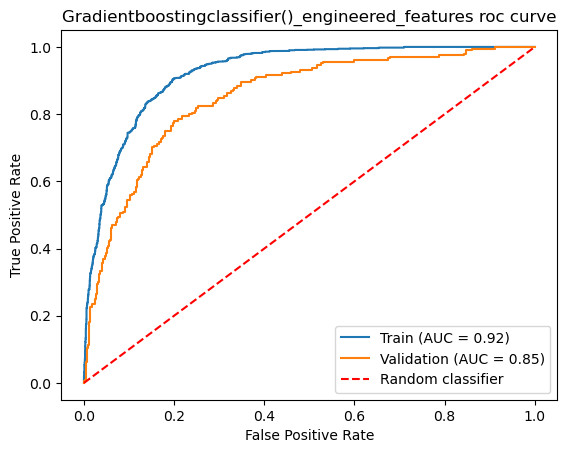

C:\Users\dor.meir\AppData\Local\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


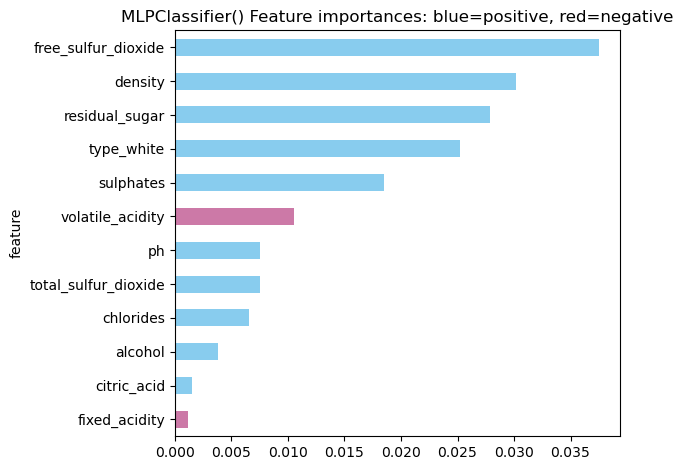

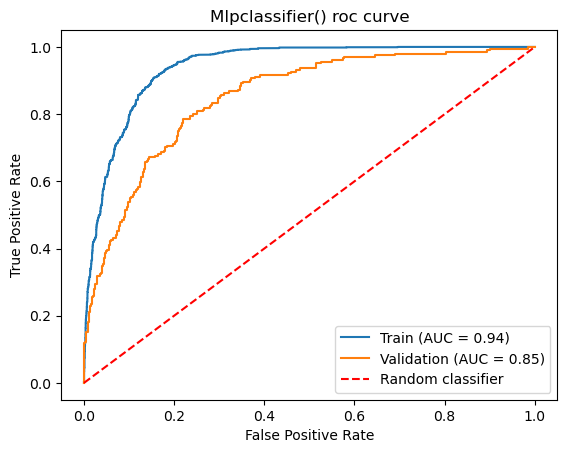

C:\Users\dor.meir\AppData\Local\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


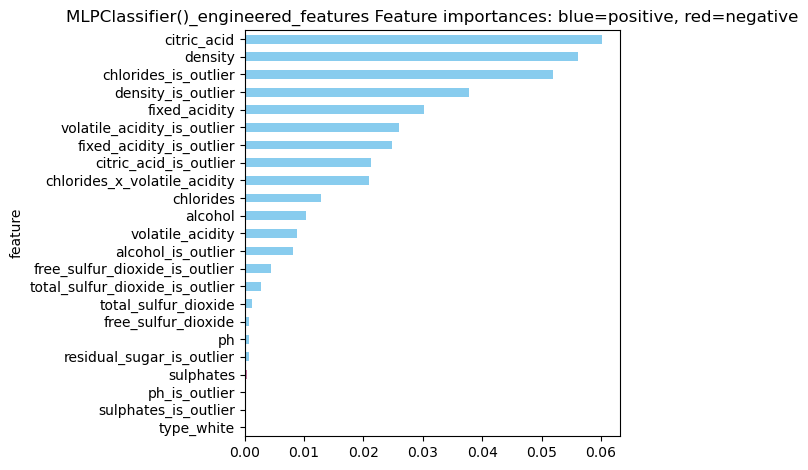

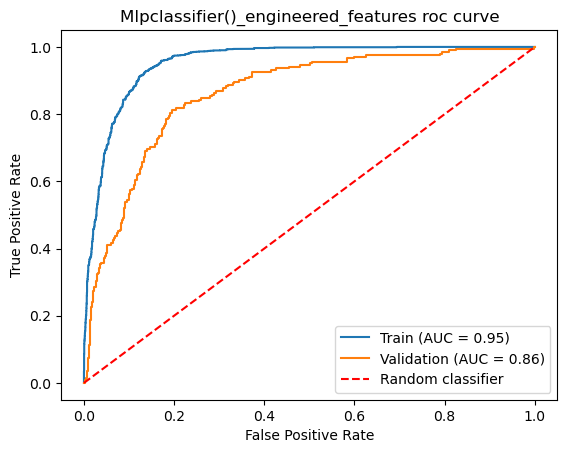

,train_timestamp,model,hyper_parameters,"('support', '1')","('support', '0')",TP,FP,TN,FN,accuracy,"('distribution', '1')","('precision', '1')","('lift', '1')","('recall', '1')","('f1-score', '1')",AUC,"('precision', '0')","('lift', '0')","('recall', '0')","('f1-score', '0')",feature_importance
baseline,2023-07-16 09:12:45,GaussianNB(),"{'priors': None, 'var_smoothing': 1e-09}",204,836,157,312,524,47,0.654808,0.196154,0.334755,1.706593,0.769608,0.466568,0.756081,0.917688,1.141622,0.626794,0.744847,"{'type_white': 0.037, 'chlorides': -0.024, 'fi..."
baseline_engineered_features,2023-07-25 09:49:12,GaussianNB(),"{'priors': None, 'var_smoothing': 1e-09}",204,836,202,792,44,2,0.236538,0.196154,0.203219,1.036020,0.990196,0.337229,0.748156,0.956522,1.189931,0.052632,0.099773,"{'volatile_acidity': 0.006, 'residual_sugar_is..."
KNeighborsClassifier(),2023-07-25 09:50:55,KNeighborsClassifier(),"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",204,836,158,204,632,46,0.759615,0.196154,0.436464,2.225111,0.774510,0.558304,0.835805,0.932153,1.159617,0.755981,0.834875,"{'type_white': 0.045, 'sulphates': 0.026, 'fre..."
KNeighborsClassifier()_engineered_features,2023-07-25 09:51:02,KNeighborsClassifier(),"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",204,836,157,182,654,47,0.779808,0.196154,0.463127,2.361039,0.769608,0.578269,0.829516,0.932953,1.160611,0.782297,0.851008,"{'fixed_acidity_is_outlier': 0.057, 'alcohol_i..."
SVC(probability=True),2023-07-25 09:51:26,SVC(probability=True),"{'C': 1.0, 'break_ties': False, 'cache_size': ...",204,836,171,225,611,33,0.751923,0.196154,0.431818,2.201426,0.838235,0.570000,0.853038,0.948758,1.180273,0.730861,0.825676,"{'volatile_acidity': -0.018, 'type_white': 0.0..."
SVC(probability=True)_engineered_features,2023-07-25 09:52:11,SVC(probability=True),"{'C': 1.0, 'break_ties': False, 'cache_size': ...",204,836,173,232,604,31,0.747115,0.196154,0.427160,2.177681,0.848039,0.568144,0.854193,0.951181,1.183287,0.722488,0.821210,"{'free_sulfur_dioxide': -0.021, 'chlorides_is_..."
LogisticRegression(),2023-07-25 09:52:11,LogisticRegression(),"{'C': 1.0, 'class_weight': None, 'dual': False...",204,836,154,252,584,50,0.709615,0.196154,0.379310,1.933739,0.754902,0.504918,0.801564,0.921136,1.145910,0.698565,0.794558,"{'fixed_acidity': 0.348, 'volatile_acidity': -..."
LogisticRegression()_engineered_features,2023-07-25 09:52:11,LogisticRegression(),"{'C': 1.0, 'class_weight': None, 'dual': False...",204,836,153,254,582,51,0.706731,0.196154,0.375921,1.916462,0.750000,0.500818,0.806402,0.919431,1.143790,0.696172,0.792376,"{'fixed_acidity': 0.412, 'volatile_acidity': -..."
DecisionTreeClassifier(),2023-07-25 09:52:12,DecisionTreeClassifier(),"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",204,836,125,80,756,79,0.847115,0.196154,0.609756,3.108560,0.612745,0.611247,0.758526,0.905389,1.126322,0.904306,0.904847,"{'fixed_acidity': 0.054, 'volatile_acidity': 0..."
DecisionTreeClassifier()_engineered_features,2023-07-25 09:52:12,DecisionTreeClassifier(),"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",204,836,101,82,754,103,0.822115,0.196154,0.551913,2.813672,0.495098,0.521964,0.698506,0.879813,1.094505,0.901914,0.890727,"{'fixed_acidity': 0.046, 'volatile_acidity': 0..."


In [28]:
def train_evaluate_plot_report_sklearn_classification_model(the_model, the_X_train, the_y_train, the_X_val, the_y_val, the_model_name=None, export_metrics_to_csv=True, to_plot=True):
    """
    For a given model instantiation and train and validation datasets, train a model, plot feature importance and ROC curve, and import, export and return updated model metrics dataframe
    :param the_model: Instantiation of a sklearn model
    :param the_X_train: a DataFrame of the train features
    :param the_y_train: a DataFrame of the train target
    :param the_X_val: a DataFrame of the validation features
    :param the_y_val: a DataFrame of the validation target
    :param the_model_name: a string of the model name, will be used for plotting title and updating the model metrics dataframe
    :param export_metrics_to_csv: export updated model metrics back to csv file
    :param to_plot: a boolean for plotting feature importance and ROC curve
    :return: the DataFrame model metrics, appended with the trained model results
    """
    the_model = the_model.fit(the_X_train.values, the_y_train.values)
    y_pred = the_model.predict(the_X_val.values)

    if hasattr(the_model, 'feature_importances_'): # Tree based algorithms
        feature_importance = the_model.feature_importances_
        feature_importance = pd.DataFrame({'feature': the_X_train.columns, 'importance': feature_importance})
        feature_importance = feature_importance.set_index('feature')
    elif hasattr(the_model, 'coef_'): # logistic regression coefficients
        coefficients = the_model.coef_[0]
        feature_importance = pd.DataFrame({'feature': the_X_train.columns, 'importance': coefficients})
        feature_importance = feature_importance.set_index('feature')
    else: # permutation importance
        feature_importance = get_permutation_importance(the_model, the_X_train, the_X_val, the_y_val)

    if the_model_name is None:
        the_model_name= str(the_model)
    the_y_prob_train = the_model.predict_proba(the_X_train.values)[:, [1]]
    the_y_prob_val = the_model.predict_proba(the_X_val.values)[:, [1]]


    if to_plot:
        plot_feature_importance(feature_importance, show_sign_color=True, show_only_important=True, model_name=the_model_name)
        plot_roc_curves(the_y_train, the_y_prob_train, the_y_val, the_y_prob_val, model_name=the_model_name)

    model_params=the_model.get_params()
    the_model_metrics = get_model_metrics(the_y_val, y_pred, the_y_prob_val,
                                      feature_importance, model=model,
                                      model_params=model_params,
                                      model_name=the_model_name,
                                      export_to_csv=export_metrics_to_csv)
    return the_model_metrics

types_of_features_to_drop = ['is_engineered']
## drop engineered features:
drop_features_with_train_statistics_property_fn = partial(
    drop_features_with_train_statistics_property, the_train_statistics=train_statistics,
    property_list=types_of_features_to_drop, errors=dropping_errors)
X_train_orig = drop_features_with_train_statistics_property_fn(X_train)
X_val_orig = drop_features_with_train_statistics_property_fn(X_val)

# create a partial function for all models that will be trained on the dataset WITHOUT engineered features
train_evaluate_plot_report_sklearn_classification_model_original_features = partial(train_evaluate_plot_report_sklearn_classification_model, the_X_train=X_train_orig, the_y_train=y_train, the_X_val=X_val_orig, the_y_val=y_val, export_metrics_to_csv=True, to_plot=True)
# create a partial function for all models that will be trained on the dataset WITH engineered features
train_evaluate_plot_report_sklearn_classification_model_engineered_features = partial(train_evaluate_plot_report_sklearn_classification_model, the_X_train=X_train, the_y_train=y_train, the_X_val=X_val, the_y_val=y_val, export_metrics_to_csv=True)

from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model_name_engineered = str(model) + "_engineered_features"
train_evaluate_plot_report_sklearn_classification_model_original_features(the_model=model)
train_evaluate_plot_report_sklearn_classification_model_engineered_features(the_model=model, the_model_name=model_name_engineered)

from sklearn.svm import SVC
model = SVC(probability=True)
model_name_engineered = str(model) + "_engineered_features"
train_evaluate_plot_report_sklearn_classification_model_original_features(the_model=model)
train_evaluate_plot_report_sklearn_classification_model_engineered_features(the_model=model, the_model_name=model_name_engineered)

from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model_name_engineered = str(model) + "_engineered_features"
train_evaluate_plot_report_sklearn_classification_model_original_features(the_model=model)
train_evaluate_plot_report_sklearn_classification_model_engineered_features(the_model=model, the_model_name=model_name_engineered)

from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model_name_engineered = str(model) + "_engineered_features"
train_evaluate_plot_report_sklearn_classification_model_original_features(the_model=model)
train_evaluate_plot_report_sklearn_classification_model_engineered_features(the_model=model, the_model_name=model_name_engineered)

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model_name_engineered = str(model) + "_engineered_features"
train_evaluate_plot_report_sklearn_classification_model_original_features(the_model=model)
train_evaluate_plot_report_sklearn_classification_model_engineered_features(the_model=model, the_model_name=model_name_engineered)

from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier()
model_name_engineered = str(model) + "_engineered_features"
train_evaluate_plot_report_sklearn_classification_model_original_features(the_model=model)
train_evaluate_plot_report_sklearn_classification_model_engineered_features(the_model=model, the_model_name=model_name_engineered)


from sklearn.neural_network import MLPClassifier
model = MLPClassifier()
model_name_engineered = str(model) + "_engineered_features"
train_evaluate_plot_report_sklearn_classification_model_original_features(the_model=model)
train_evaluate_plot_report_sklearn_classification_model_engineered_features(the_model=model, the_model_name=model_name_engineered)

In [11]:
feature_importance

,importance
feature,
density,0.061731
fixed_acidity_is_outlier,0.040385
chlorides_is_outlier,0.026346
alcohol_is_outlier,-0.011154
citric_acid,0.009615
free_sulfur_dioxide,0.009038
fixed_acidity,0.006923
alcohol,0.006346
density_is_outlier,0.004038
